In [1]:
!pip install thop ptflops

In [5]:
"""
USC-HAD Dataset Analysis
Show number of samples per subject per class
"""

import numpy as np
import os
import scipy.io as scio
from collections import Counter, defaultdict
import pandas as pd

# USC-HAD has 12 activity classes
ACTIVITIES = {
    0: 'Walking Forward',
    1: 'Walking Left',
    2: 'Walking Right',
    3: 'Walking Upstairs',
    4: 'Walking Downstairs',
    5: 'Running Forward',
    6: 'Jumping',
    7: 'Sitting',
    8: 'Standing',
    9: 'Sleeping',
    10: 'Elevator Up',
    11: 'Elevator Down'
}

def slide_window(array, w_s, stride):
    """
    Apply sliding window
    """
    x = []
    times = (array.shape[0] - w_s) // stride + 1
    i = 0
    for i in range(times):
        x.append(array[stride*i: stride*i+w_s])

    # Keep the last window
    if stride*i+w_s < array.shape[0]-1:
        x.append(array[-w_s:])
    return x


def load_uschad_data(path, w_s=100, stride=50):
    """
    Load USC-HAD data and return subject_id, data, labels

    Parameters:
    -----------
    path : str
        Path to USC-HAD dataset folder
    w_s : int
        Window size
    stride : int
        Stride for sliding window

    Returns:
    --------
    subject_ids : array
        Subject ID for each sample
    data : array
        Sensor data
    labels : array
        Activity labels
    """
    result = []
    subject_ids = []
    labels = []

    # Get subject folders
    subject_list = os.listdir(path)
    subject_list = [subject for subject in subject_list if subject.find('Subject') != -1]
    subject_list = sorted(subject_list)

    print(f"{'='*60}")
    print("Loading USC-HAD Dataset")
    print(f"{'='*60}")
    print(f"Found {len(subject_list)} subjects")
    print(f"Window size: {w_s}, Stride: {stride}")
    print(f"{'='*60}\n")

    os.chdir(path)

    for i, subject in enumerate(subject_list):
        if not os.path.isdir(subject):
            continue

        subject_num = i + 1
        print(f"Loading {subject}...")

        mat_list = os.listdir(subject)
        os.chdir(subject)

        for mat in mat_list:
            if not mat.endswith('.mat'):
                continue

            # Extract class from filename
            category = int(mat[1:-6]) - 1  # Get activity class

            # Load .mat file
            content = scio.loadmat(mat)['sensor_readings']

            # Apply sliding window
            x = slide_window(content, w_s, stride)

            result.extend(x)
            subject_ids.extend([subject_num] * len(x))
            labels.extend([category] * len(x))

        os.chdir('../')

    os.chdir('../')

    return np.array(subject_ids, dtype=int), np.expand_dims(np.array(result), axis=1), np.array(labels, dtype=int)


def analyze_samples_per_subject_per_class(subject_ids, labels):
    """
    Analyze samples per subject per class
    """
    # Create a nested dictionary: {subject: {class: count}}
    subject_class_counts = defaultdict(lambda: defaultdict(int))

    for subject_id, label in zip(subject_ids, labels):
        subject_class_counts[subject_id][label] += 1

    print(f"\n{'='*80}")
    print("SAMPLES PER SUBJECT PER CLASS")
    print(f"{'='*80}")

    # Create header
    header = f"{'Subject':<10}"
    for class_id in range(12):
        header += f"{'C' + str(class_id):<8}"
    header += f"{'Total':<10}"
    print(header)
    print('-' * 80)

    # Print data for each subject
    total_per_class = defaultdict(int)

    for subject_id in sorted(subject_class_counts.keys()):
        row = f"{subject_id:<10}"
        subject_total = 0

        for class_id in range(12):
            count = subject_class_counts[subject_id][class_id]
            row += f"{count:<8}"
            subject_total += count
            total_per_class[class_id] += count

        row += f"{subject_total:<10}"
        print(row)

    # Print totals
    print('-' * 80)
    total_row = f"{'Total':<10}"
    grand_total = 0
    for class_id in range(12):
        total_row += f"{total_per_class[class_id]:<8}"
        grand_total += total_per_class[class_id]
    total_row += f"{grand_total:<10}"
    print(total_row)
    print(f"{'='*80}\n")

    return subject_class_counts


def print_detailed_stats(subject_ids, labels):
    """
    Print detailed statistics per subject
    """
    unique_subjects = np.unique(subject_ids)

    print(f"\n{'='*60}")
    print("DETAILED STATISTICS PER SUBJECT")
    print(f"{'='*60}\n")

    for subject_id in sorted(unique_subjects):
        mask = subject_ids == subject_id
        subject_labels = labels[mask]

        print(f"Subject {subject_id}:")
        print(f"  Total samples: {len(subject_labels)}")

        counter = Counter(subject_labels)
        print(f"  Classes present: {sorted(counter.keys())}")
        print(f"  Sample distribution:")

        for class_id in sorted(counter.keys()):
            activity_name = ACTIVITIES.get(class_id, f'Unknown_{class_id}')
            print(f"    Class {class_id} ({activity_name}): {counter[class_id]} samples")

        print()


def create_summary_dataframe(subject_ids, labels):
    """
    Create a pandas DataFrame for easy viewing
    """
    subject_class_counts = defaultdict(lambda: defaultdict(int))

    for subject_id, label in zip(subject_ids, labels):
        subject_class_counts[subject_id][label] += 1

    # Convert to DataFrame
    data = []
    for subject_id in sorted(subject_class_counts.keys()):
        row = {'Subject': subject_id}
        for class_id in range(12):
            row[f'C{class_id}'] = subject_class_counts[subject_id][class_id]
        row['Total'] = sum(subject_class_counts[subject_id].values())
        data.append(row)

    df = pd.DataFrame(data)

    print(f"\n{'='*60}")
    print("SUMMARY TABLE")
    print(f"{'='*60}")
    print(df.to_string(index=False))
    print(f"{'='*60}\n")

    return df


def main():
    """
    Main function
    """
    # Set your dataset path
    dataset_path = '/content/drive/MyDrive/HAR_Dataset/USC'

    print("="*60)
    print("USC-HAD Dataset Analysis")
    print("="*60)
    print(f"Dataset path: {dataset_path}\n")

    if not os.path.exists(dataset_path):
        print(f"❌ Dataset path not found: {dataset_path}")
        print("Please update the dataset_path variable.")
        return

    # Load data
    window_size = 100
    overlap_rate = 0.5
    stride = int(window_size * (1 - overlap_rate))

    subject_ids, data, labels = load_uschad_data(
        path=dataset_path,
        w_s=window_size,
        stride=stride
    )

    print(f"\n{'='*60}")
    print("DATA LOADED")
    print(f"{'='*60}")
    print(f"Total samples: {len(subject_ids)}")
    print(f"Number of subjects: {len(np.unique(subject_ids))}")
    print(f"Number of classes: {len(np.unique(labels))}")
    print(f"Data shape: {data.shape}")
    print(f"{'='*60}")

    # Analyze samples per subject per class
    analyze_samples_per_subject_per_class(subject_ids, labels)

    # Print detailed statistics
    print_detailed_stats(subject_ids, labels)

    # Create summary DataFrame
    df = create_summary_dataframe(subject_ids, labels)


if __name__ == "__main__":
    main()

USC-HAD Dataset Analysis
Dataset path: /content/drive/MyDrive/HAR_Dataset/USC

Loading USC-HAD Dataset
Found 14 subjects
Window size: 100, Stride: 50

Loading Subject1...
Loading Subject10...
Loading Subject11...
Loading Subject12...
Loading Subject13...
Loading Subject14...
Loading Subject2...
Loading Subject3...
Loading Subject4...
Loading Subject5...
Loading Subject6...
Loading Subject7...
Loading Subject8...
Loading Subject9...

DATA LOADED
Total samples: 55456
Number of subjects: 14
Number of classes: 12
Data shape: (55456, 1, 100, 6)

SAMPLES PER SUBJECT PER CLASS
Subject   C0      C1      C2      C3      C4      C5      C6      C7      C8      C9      C10     C11     Total     
--------------------------------------------------------------------------------
1         241     323     369     609     569     159     135     395     185     495     191     181     3852      
2         849     331     349     613     555     297     94      395     395     495     295     263     49

Device: cuda

LOADING USC-HAD DATASET
Loading USC-HAD: Found 14 subjects. (w_s=100, stride=50)
Data shape: (55456, 6, 100)
Labels: ['Walking Forward', 'Walking Left', 'Walking Right', 'Walking Upstairs', 'Walking Downstairs', 'Running Forward', 'Jumping', 'Sitting', 'Standing', 'Sleeping', 'Elevator Up', 'Elevator Down']
Total subjects: 14

Train subjects: 9 users (IDs: [1 2 3 4 5 6 7 8 9])
Val subjects: 2 users (IDs: [10 11])
Test subjects: 3 users (IDs: [12 13 14])

Train samples: 30771
Val samples: 10136
Test samples: 14549

STARTING FULL EXPERIMENT RUN FOR: K-TRAIN = 1-SHOT

BUILDING UNCERTAINTY-AWARE PROTOTYPE NETWORK

MODEL ARCHITECTURE & PERFORMANCE STATS


,Metric,Value
0,Parameters (M),0.40
1,FLOPs (M),4.40
2,Inference Time (ms),11.45



META-TRAINING (K=1, 2000 Episodes)

Episode    0 | Loss: 1.0462 | Train Acc: 0.8000 | Val Acc: 0.0853
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 
Episode  200 | Loss: 0.1297 | Train Acc: 1.0000 | Val Acc: 0.6850
210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 
Episode  400 | Loss: 0.1658 | Train Acc: 0.9467 | Val Acc: 0.7206
410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 
Episode  600 | Loss: 0.2441 | Train Acc: 0.9576 | Val Acc: 0.8039
610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 
Episode  800 | Loss: 0.3159 | Train Acc: 0.9333 | Val Acc: 0.8042
810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 
Episode 1000 | Loss: 0.1008 | Train Acc: 1.0000 | Val Acc: 0.8236
1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 
Episode 1200 | Loss: 0.4503 | Train Acc: 0.8242 | Val Acc: 0.7731
121

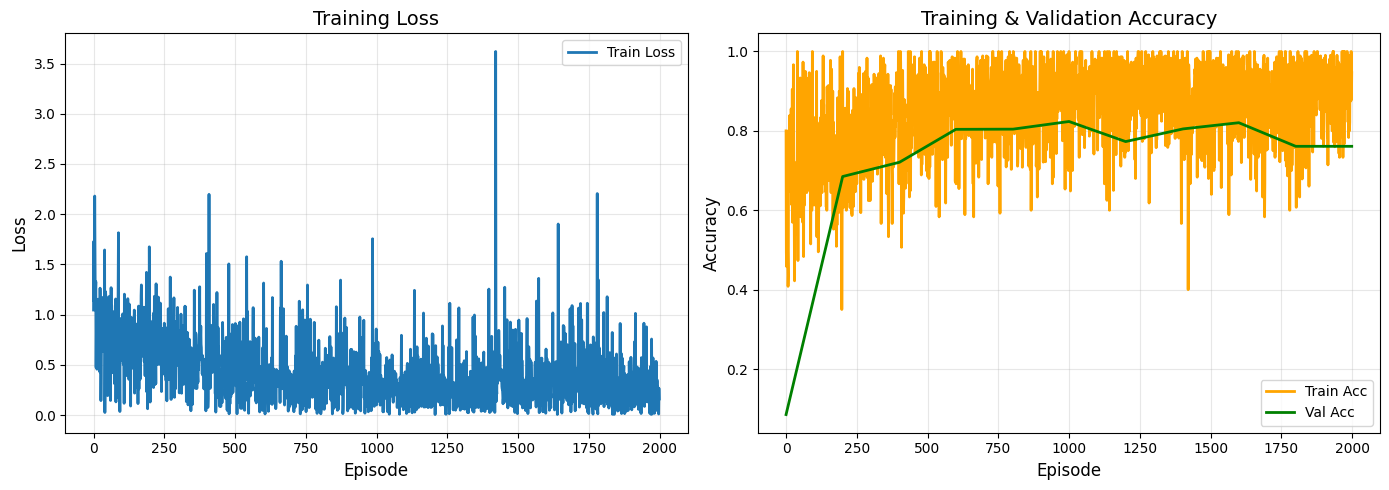

Displayed: learning_curves_k1.png

META-TESTING: 12-WAY, 1-SHOT PERFORMANCE (CROSS-DOMAIN)

OVERALL RESULTS (LSSO SPLIT):


,Metric,Value
0,Accuracy,0.6776
1,F1-Score (macro),0.6776
2,Precision (macro),0.6777
3,Recall (macro),0.6776



PER-CLASS ACCURACY (LSSO SPLIT):


,Class,Accuracy
0,Walking Forward,0.6593
1,Walking Left,0.6730
2,Walking Right,0.6517
3,Walking Upstairs,0.6997
4,Walking Downstairs,0.6560
5,Running Forward,0.6900
6,Jumping,0.6650
7,Sitting,0.7077
8,Standing,0.6943
9,Sleeping,0.6747


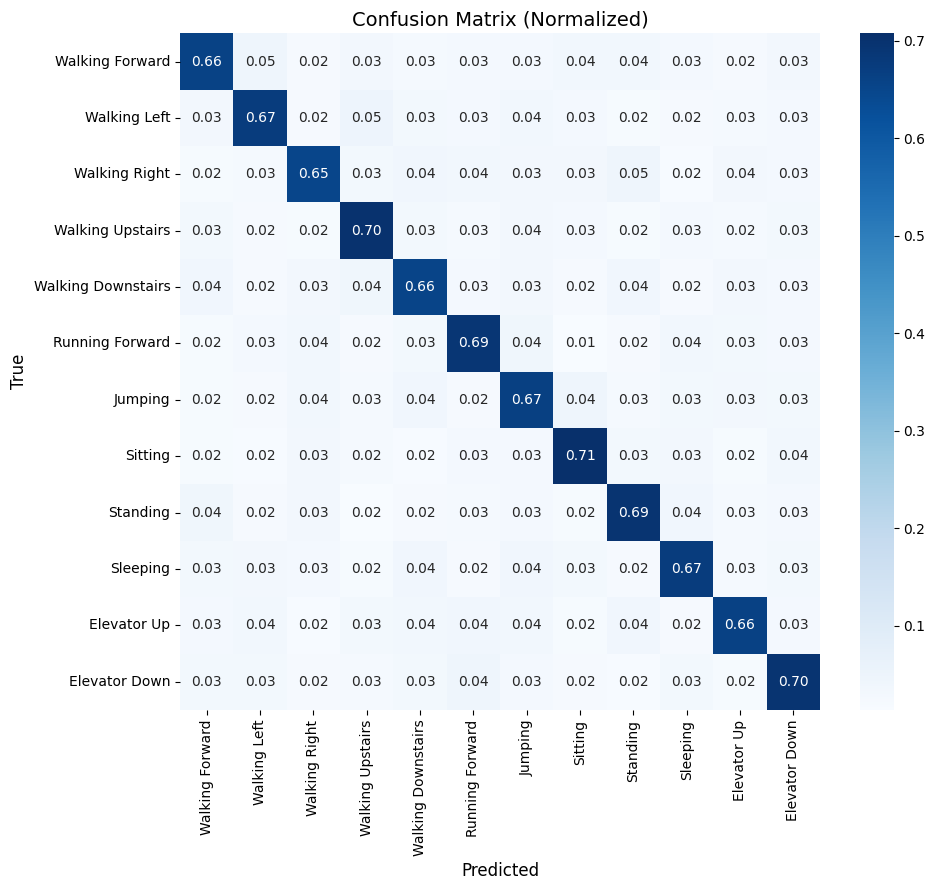


Displayed: cm_k1.png

K-SHOT ABLATION STUDY
Testing 1-shot...
Testing 3-shot...
Testing 5-shot...
Testing 10-shot...
Testing 20-shot...

K-SHOT COMPARISON:


,K-Shot,Accuracy,F1,Precision,Recall
0,1,0.6964,0.6963,0.6969,0.6964
1,3,0.7222,0.7221,0.7227,0.7222
2,5,0.7526,0.7525,0.7530,0.7526
3,10,0.7573,0.7574,0.7579,0.7573
4,20,0.7530,0.7528,0.7532,0.7530


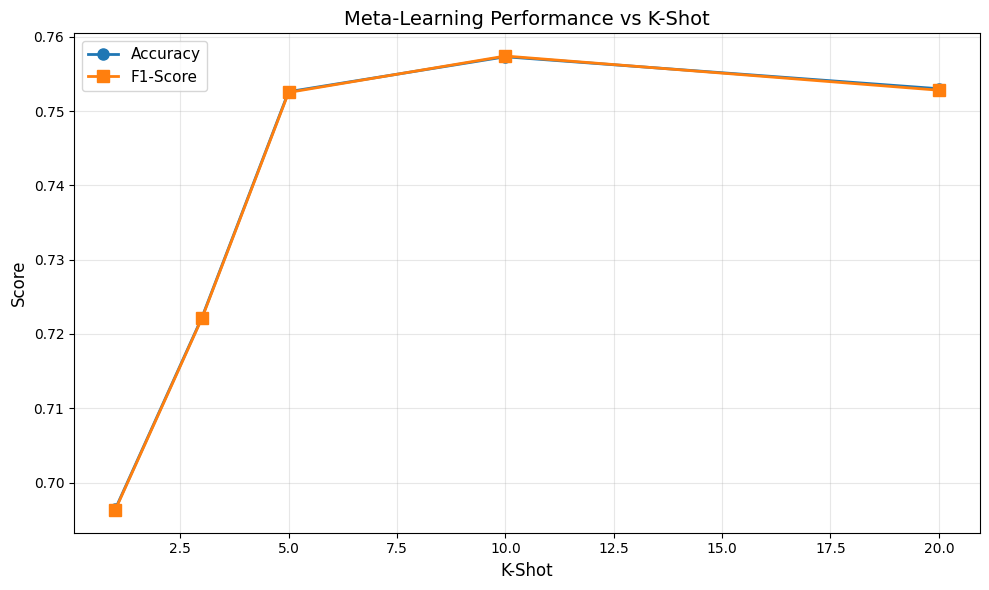


Displayed: kshot_comparison_k1.png

N-WAY ABLATION STUDY (K=1)
Testing 4-way...
Testing 6-way...
Testing 8-way...
Testing 10-way...
Testing 12-way...

N-WAY COMPARISON:


,N-Way,Accuracy,F1,Precision,Recall
0,4,0.8420,0.8420,0.8424,0.8420
1,6,0.7960,0.7960,0.7962,0.7960
2,8,0.7667,0.7665,0.7669,0.7667
3,10,0.7164,0.7162,0.7166,0.7164
4,12,0.6791,0.6791,0.6797,0.6791



QUERY SET SIZE ABLATION (K=1)
Testing query=5...
Testing query=10...
Testing query=15...
Testing query=20...
Testing query=25...

QUERY SIZE COMPARISON:


,Query Size (q),Accuracy,F1,Precision,Recall
0,5,0.6707,0.6708,0.6719,0.6707
1,10,0.6890,0.6887,0.6896,0.6890
2,15,0.6794,0.6790,0.6792,0.6794
3,20,0.6840,0.6842,0.6849,0.6840
4,25,0.6756,0.6755,0.6757,0.6756



PER-USER PERSONALIZATION (ON TEST SET, K=1)


,User,Accuracy,F1,Precision,Recall
0,12,0.8130,0.8131,0.8138,0.8130
1,13,0.6887,0.6886,0.6903,0.6887
2,14,0.5537,0.5537,0.5557,0.5537



Mean User Accuracy (Test Set): 0.6851 ± 0.1059


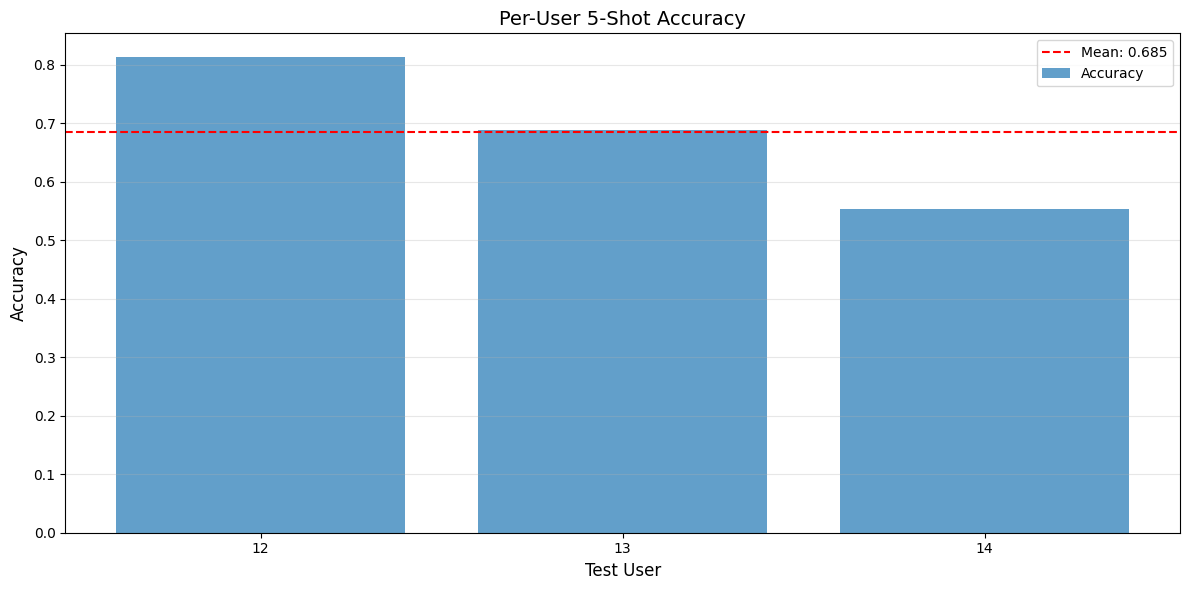

Displayed: user_performance_k1.png

FEATURE CALIBRATION / VARIANCE ANALYSIS


,Intra-Class Variance (L2),Inter-Class Variance (L2),Separation Ratio (Inter/Intra)
0,2.3029,4.7009,2.0413



ROBUSTNESS TEST (NOISY QUERY, K=1)
... Testing Robustness: Type=jitter, Level=0.1
    -> Acc: 0.6771, F1: 0.6773
... Testing Robustness: Type=jitter, Level=0.2
    -> Acc: 0.6834, F1: 0.6835
... Testing Robustness: Type=jitter, Level=0.3
    -> Acc: 0.6567, F1: 0.6568
... Testing Robustness: Type=dropout, Level=0.1
    -> Acc: 0.6611, F1: 0.6610
... Testing Robustness: Type=dropout, Level=0.2
    -> Acc: 0.6287, F1: 0.6284
... Testing Robustness: Type=dropout, Level=0.3
    -> Acc: 0.5799, F1: 0.5797
... Testing Robustness: Type=shift, Level=0.1
    -> Acc: 0.6845, F1: 0.6844
... Testing Robustness: Type=shift, Level=0.2
    -> Acc: 0.6777, F1: 0.6778
... Testing Robustness: Type=shift, Level=0.3
    -> Acc: 0.6567, F1: 0.6566

STARTING LEAVE-ONE-SUBJECT-OUT (LOSO) EXPERIMENT
Total Subjects: 14. This will run 14 training sessions.

--- LOSO Run 1/14: Testing on User 1 ---
Meta-Training for User 1...

Episode    0 | Loss: 2.6725 | Train Acc: 0.3556 | Val Acc: 0.0822
10 20 30 40 50 60 7

,User,Accuracy,F1,Precision,Recall
0,1,0.6158,0.6157,0.6176,0.6158
1,2,0.6708,0.6707,0.6712,0.6708
2,3,0.7857,0.7856,0.7865,0.7857
3,4,0.6646,0.6642,0.6648,0.6646
4,5,0.7553,0.7555,0.7563,0.7553
5,6,0.7893,0.7895,0.7921,0.7893
6,7,0.7720,0.7722,0.7730,0.7720
7,8,0.6842,0.6839,0.6848,0.6842
8,9,0.7066,0.7060,0.7066,0.7066
9,10,0.7902,0.7902,0.7912,0.7902



Mean LOSO Accuracy: 0.7080 ± 0.0730

LOSO EXPERIMENT FINAL SUMMARY (K=1)

Overall LOSO Mean Accuracy (14 Users): 0.7080 ± 0.0730
Overall LOSO Mean F1 (14 Users): 0.7079

COMPREHENSIVE SUMMARY FOR K-TRAIN = 1

STARTING FULL EXPERIMENT RUN FOR: K-TRAIN = 2-SHOT

BUILDING UNCERTAINTY-AWARE PROTOTYPE NETWORK

MODEL ARCHITECTURE & PERFORMANCE STATS


,Metric,Value
0,Parameters (M),0.40
1,FLOPs (M),4.40
2,Inference Time (ms),9.50



META-TRAINING (K=2, 2000 Episodes)

Episode    0 | Loss: 1.3575 | Train Acc: 0.7619 | Val Acc: 0.0828
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 
Episode  200 | Loss: 0.2603 | Train Acc: 0.9185 | Val Acc: 0.7722
210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 
Episode  400 | Loss: 0.2664 | Train Acc: 0.8370 | Val Acc: 0.7981
410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 
Episode  600 | Loss: 0.2610 | Train Acc: 0.9083 | Val Acc: 0.8144
610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 
Episode  800 | Loss: 0.1440 | Train Acc: 0.9667 | Val Acc: 0.8136
810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 
Episode 1000 | Loss: 0.1957 | Train Acc: 0.9733 | Val Acc: 0.8081
1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 
Episode 1200 | Loss: 0.1283 | Train Acc: 0.9778 | Val Acc: 0.8258
121

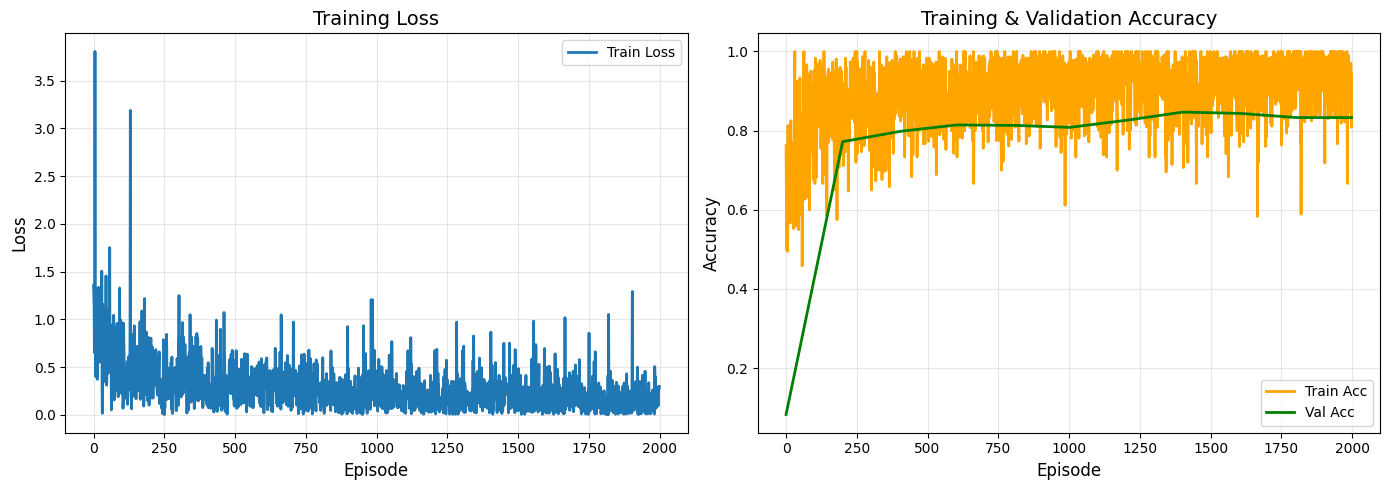

Displayed: learning_curves_k2.png

META-TESTING: 12-WAY, 2-SHOT PERFORMANCE (CROSS-DOMAIN)

OVERALL RESULTS (LSSO SPLIT):


,Metric,Value
0,Accuracy,0.7253
1,F1-Score (macro),0.7253
2,Precision (macro),0.7254
3,Recall (macro),0.7253



PER-CLASS ACCURACY (LSSO SPLIT):


,Class,Accuracy
0,Walking Forward,0.7203
1,Walking Left,0.7477
2,Walking Right,0.7243
3,Walking Upstairs,0.7383
4,Walking Downstairs,0.7047
5,Running Forward,0.7200
6,Jumping,0.7253
7,Sitting,0.7117
8,Standing,0.7217
9,Sleeping,0.7350


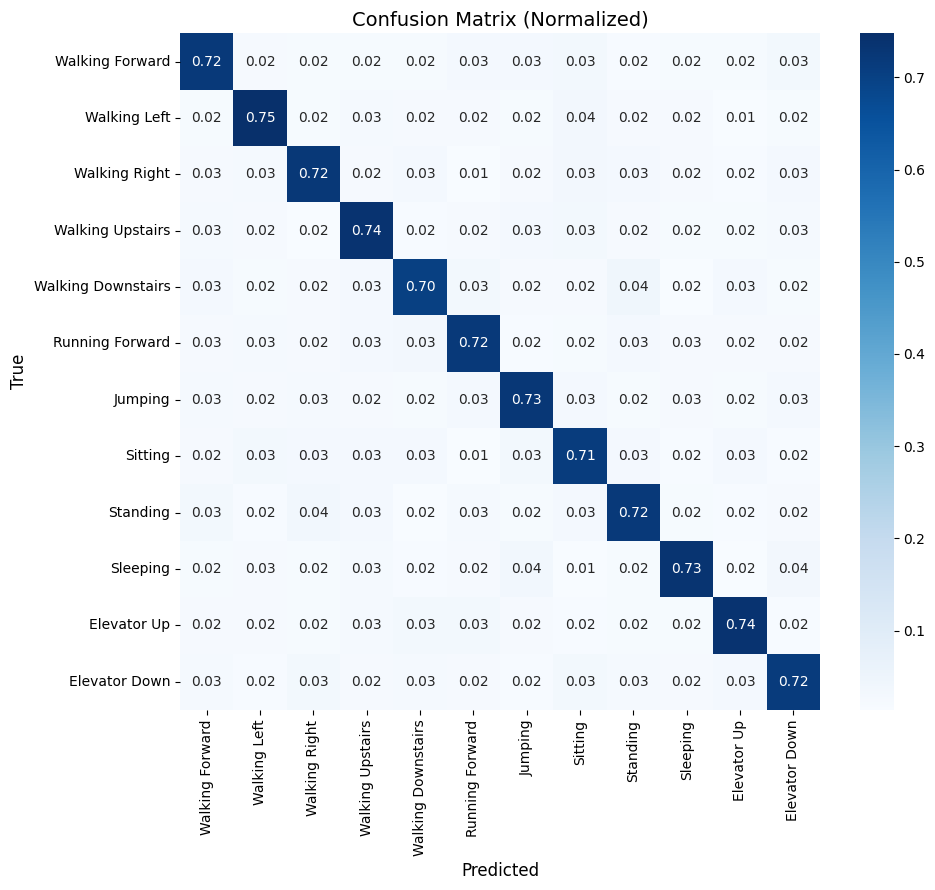


Displayed: cm_k2.png

K-SHOT ABLATION STUDY
Testing 1-shot...
Testing 3-shot...
Testing 5-shot...
Testing 10-shot...
Testing 20-shot...

K-SHOT COMPARISON:


,K-Shot,Accuracy,F1,Precision,Recall
0,1,0.6891,0.6892,0.6897,0.6891
1,3,0.7497,0.7498,0.7501,0.7497
2,5,0.7746,0.7746,0.7748,0.7746
3,10,0.7755,0.7755,0.7759,0.7755
4,20,0.7861,0.7861,0.7863,0.7861


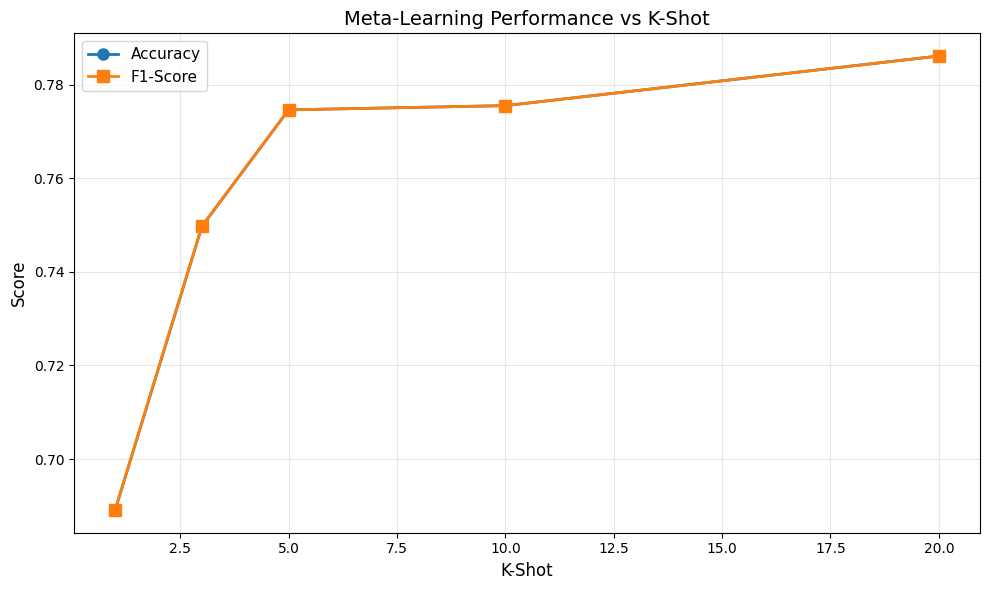


Displayed: kshot_comparison_k2.png

N-WAY ABLATION STUDY (K=2)
Testing 4-way...
Testing 6-way...
Testing 8-way...
Testing 10-way...
Testing 12-way...

N-WAY COMPARISON:


,N-Way,Accuracy,F1,Precision,Recall
0,4,0.8853,0.8853,0.8855,0.8853
1,6,0.8483,0.8483,0.8484,0.8483
2,8,0.8068,0.8070,0.8074,0.8068
3,10,0.7641,0.7641,0.7644,0.7641
4,12,0.7225,0.7226,0.7232,0.7225



QUERY SET SIZE ABLATION (K=2)
Testing query=5...
Testing query=10...
Testing query=15...
Testing query=20...
Testing query=25...

QUERY SIZE COMPARISON:


,Query Size (q),Accuracy,F1,Precision,Recall
0,5,0.7262,0.7258,0.7268,0.7262
1,10,0.7271,0.7272,0.7280,0.7271
2,15,0.7348,0.7346,0.7351,0.7348
3,20,0.7298,0.7300,0.7306,0.7298
4,25,0.7399,0.7399,0.7403,0.7399



PER-USER PERSONALIZATION (ON TEST SET, K=2)


,User,Accuracy,F1,Precision,Recall
0,12,0.8007,0.8007,0.8017,0.8007
1,13,0.7487,0.7491,0.7506,0.7487
2,14,0.6465,0.6463,0.6469,0.6465



Mean User Accuracy (Test Set): 0.7320 ± 0.0641


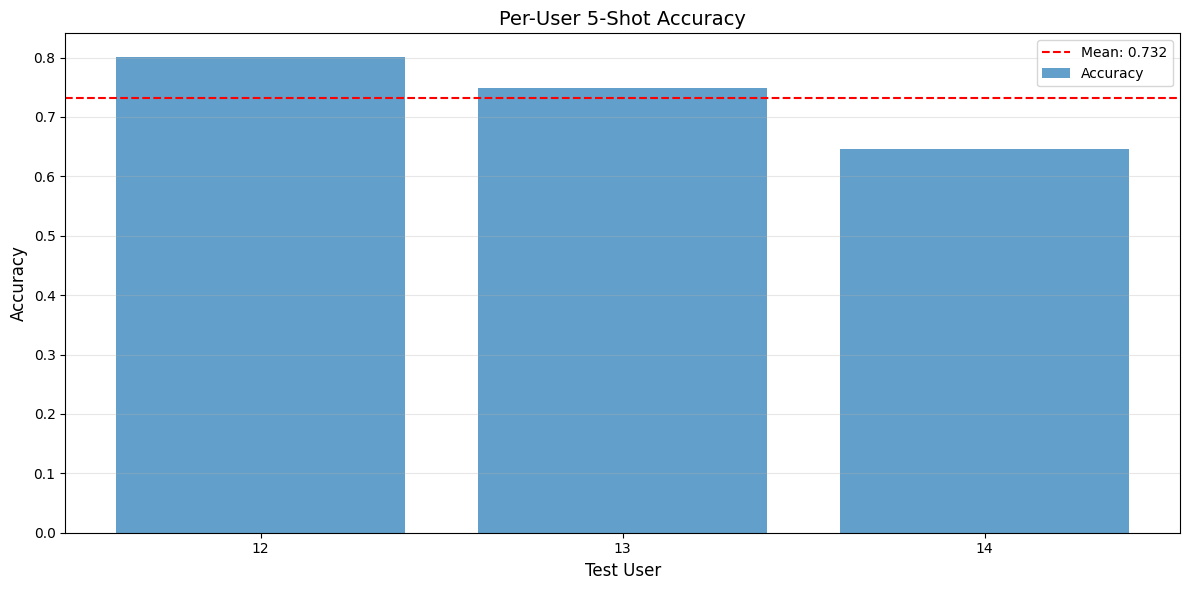

Displayed: user_performance_k2.png

FEATURE CALIBRATION / VARIANCE ANALYSIS


,Intra-Class Variance (L2),Inter-Class Variance (L2),Separation Ratio (Inter/Intra)
0,2.1998,4.6283,2.1039



ROBUSTNESS TEST (NOISY QUERY, K=2)
... Testing Robustness: Type=jitter, Level=0.1
    -> Acc: 0.7213, F1: 0.7211
... Testing Robustness: Type=jitter, Level=0.2
    -> Acc: 0.7357, F1: 0.7358
... Testing Robustness: Type=jitter, Level=0.3
    -> Acc: 0.7011, F1: 0.7009
... Testing Robustness: Type=dropout, Level=0.1
    -> Acc: 0.7274, F1: 0.7274
... Testing Robustness: Type=dropout, Level=0.2
    -> Acc: 0.7048, F1: 0.7047
... Testing Robustness: Type=dropout, Level=0.3
    -> Acc: 0.6579, F1: 0.6580
... Testing Robustness: Type=shift, Level=0.1
    -> Acc: 0.7298, F1: 0.7298
... Testing Robustness: Type=shift, Level=0.2
    -> Acc: 0.7296, F1: 0.7296
... Testing Robustness: Type=shift, Level=0.3
    -> Acc: 0.7072, F1: 0.7073

STARTING LEAVE-ONE-SUBJECT-OUT (LOSO) EXPERIMENT
Total Subjects: 14. This will run 14 training sessions.

--- LOSO Run 1/14: Testing on User 1 ---
Meta-Training for User 1...

Episode    0 | Loss: 1.9719 | Train Acc: 0.5933 | Val Acc: 0.0847
10 20 30 40 50 60 7

,User,Accuracy,F1,Precision,Recall
0,1,0.7741,0.7748,0.7766,0.7741
1,2,0.7232,0.7233,0.7242,0.7232
2,3,0.8521,0.8520,0.8523,0.8521
3,4,0.7383,0.7383,0.7389,0.7383
4,5,0.8189,0.8188,0.8191,0.8189
5,6,0.8198,0.8197,0.8202,0.8198
6,7,0.7751,0.7755,0.7768,0.7751
7,8,0.7399,0.7396,0.7405,0.7399
8,9,0.8144,0.8144,0.8152,0.8144
9,10,0.8183,0.8185,0.8200,0.8183



Mean LOSO Accuracy: 0.7707 ± 0.0694

LOSO EXPERIMENT FINAL SUMMARY (K=2)

Overall LOSO Mean Accuracy (14 Users): 0.7707 ± 0.0694
Overall LOSO Mean F1 (14 Users): 0.7706

COMPREHENSIVE SUMMARY FOR K-TRAIN = 2

STARTING FULL EXPERIMENT RUN FOR: K-TRAIN = 3-SHOT

BUILDING UNCERTAINTY-AWARE PROTOTYPE NETWORK

MODEL ARCHITECTURE & PERFORMANCE STATS


,Metric,Value
0,Parameters (M),0.40
1,FLOPs (M),4.40
2,Inference Time (ms),9.78



META-TRAINING (K=3, 2000 Episodes)

Episode    0 | Loss: 1.9404 | Train Acc: 0.4167 | Val Acc: 0.0833
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 
Episode  200 | Loss: 0.2658 | Train Acc: 0.9667 | Val Acc: 0.7397
210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 
Episode  400 | Loss: 0.2727 | Train Acc: 0.8722 | Val Acc: 0.8169
410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 
Episode  600 | Loss: 0.0321 | Train Acc: 1.0000 | Val Acc: 0.8422
610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 
Episode  800 | Loss: 0.2785 | Train Acc: 0.8800 | Val Acc: 0.8375
810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 
Episode 1000 | Loss: 0.0102 | Train Acc: 1.0000 | Val Acc: 0.8319
1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 
Episode 1200 | Loss: 0.1831 | Train Acc: 0.9000 | Val Acc: 0.8475
121

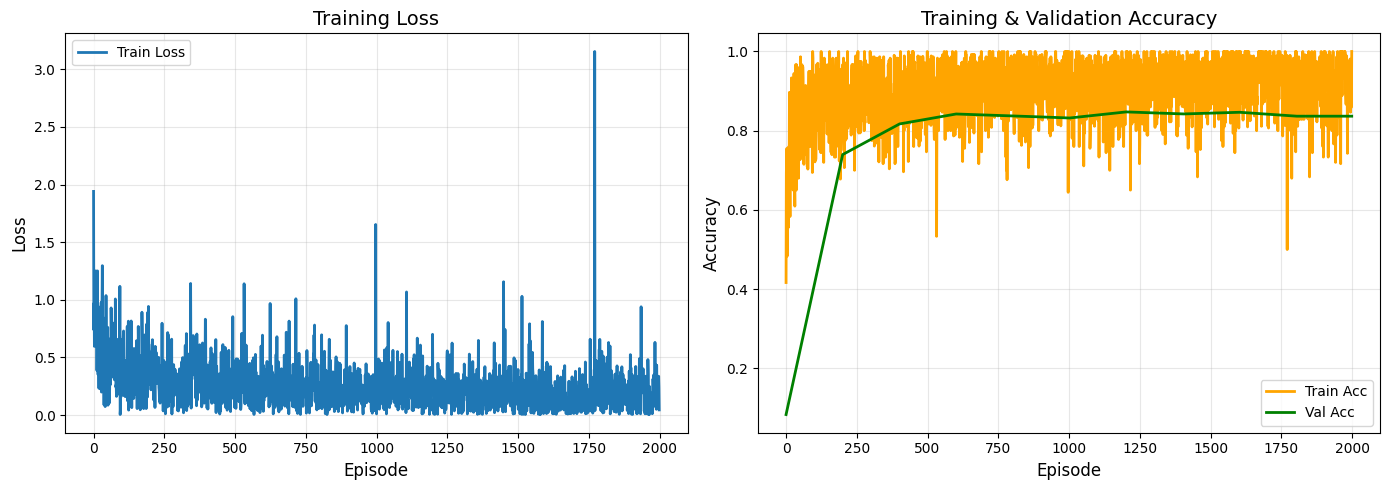

Displayed: learning_curves_k3.png

META-TESTING: 12-WAY, 3-SHOT PERFORMANCE (CROSS-DOMAIN)

OVERALL RESULTS (LSSO SPLIT):


,Metric,Value
0,Accuracy,0.7685
1,F1-Score (macro),0.7685
2,Precision (macro),0.7687
3,Recall (macro),0.7685



PER-CLASS ACCURACY (LSSO SPLIT):


,Class,Accuracy
0,Walking Forward,0.7917
1,Walking Left,0.7570
2,Walking Right,0.7690
3,Walking Upstairs,0.7710
4,Walking Downstairs,0.7673
5,Running Forward,0.7730
6,Jumping,0.7680
7,Sitting,0.7377
8,Standing,0.7663
9,Sleeping,0.7743


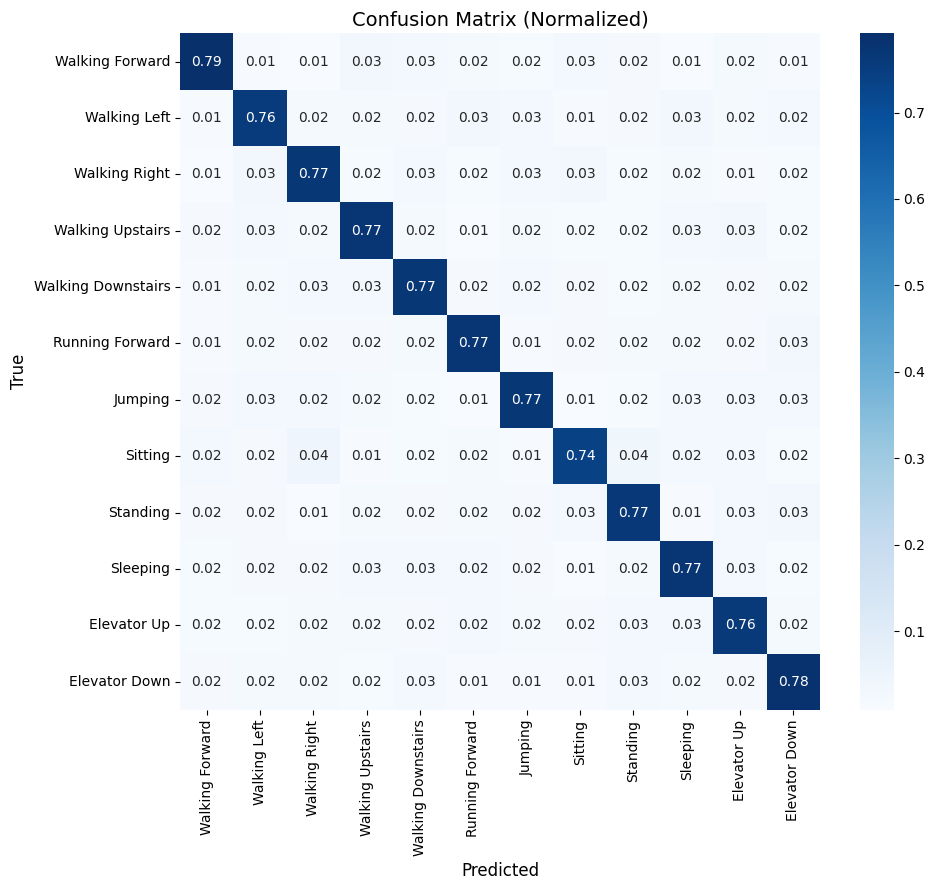


Displayed: cm_k3.png

K-SHOT ABLATION STUDY
Testing 1-shot...
Testing 3-shot...
Testing 5-shot...
Testing 10-shot...
Testing 20-shot...

K-SHOT COMPARISON:


,K-Shot,Accuracy,F1,Precision,Recall
0,1,0.6896,0.6895,0.6905,0.6896
1,3,0.7622,0.7623,0.7628,0.7622
2,5,0.7734,0.7733,0.7736,0.7734
3,10,0.7853,0.7852,0.7856,0.7853
4,20,0.8077,0.8077,0.8080,0.8077


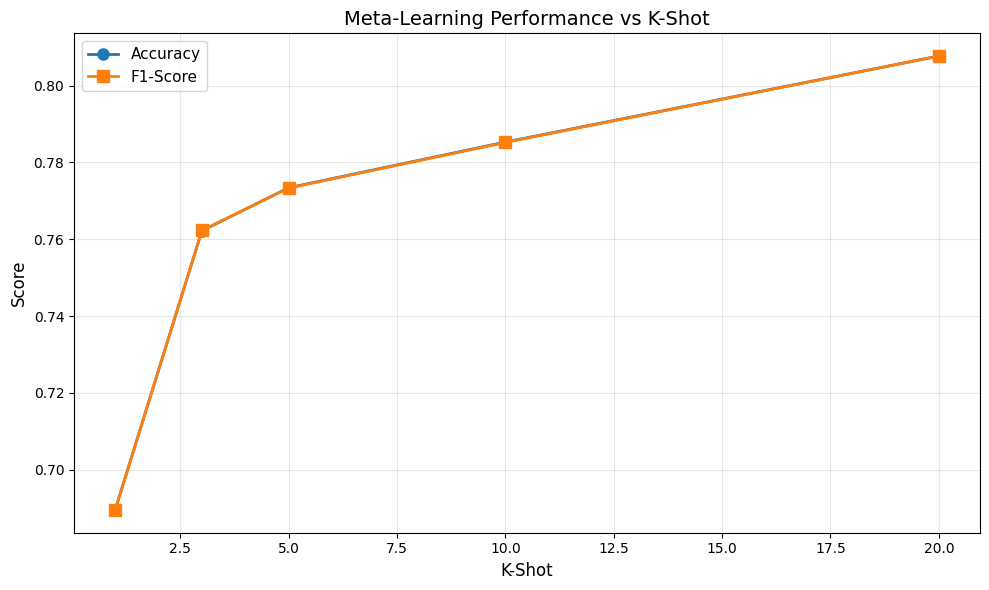


Displayed: kshot_comparison_k3.png

N-WAY ABLATION STUDY (K=3)
Testing 4-way...
Testing 6-way...
Testing 8-way...
Testing 10-way...
Testing 12-way...

N-WAY COMPARISON:


,N-Way,Accuracy,F1,Precision,Recall
0,4,0.9225,0.9225,0.9226,0.9225
1,6,0.8503,0.8504,0.8507,0.8503
2,8,0.8233,0.8233,0.8237,0.8233
3,10,0.8081,0.8080,0.8083,0.8081
4,12,0.7715,0.7716,0.7719,0.7715



QUERY SET SIZE ABLATION (K=3)
Testing query=5...
Testing query=10...
Testing query=15...
Testing query=20...
Testing query=25...

QUERY SIZE COMPARISON:


,Query Size (q),Accuracy,F1,Precision,Recall
0,5,0.7680,0.7680,0.7688,0.7680
1,10,0.7556,0.7557,0.7560,0.7556
2,15,0.7579,0.7579,0.7582,0.7579
3,20,0.7663,0.7663,0.7667,0.7663
4,25,0.7673,0.7671,0.7672,0.7673



PER-USER PERSONALIZATION (ON TEST SET, K=3)


,User,Accuracy,F1,Precision,Recall
0,12,0.8691,0.8689,0.8691,0.8691
1,13,0.7507,0.7512,0.7539,0.7507
2,14,0.6800,0.6806,0.6834,0.6800



Mean User Accuracy (Test Set): 0.7666 ± 0.0780


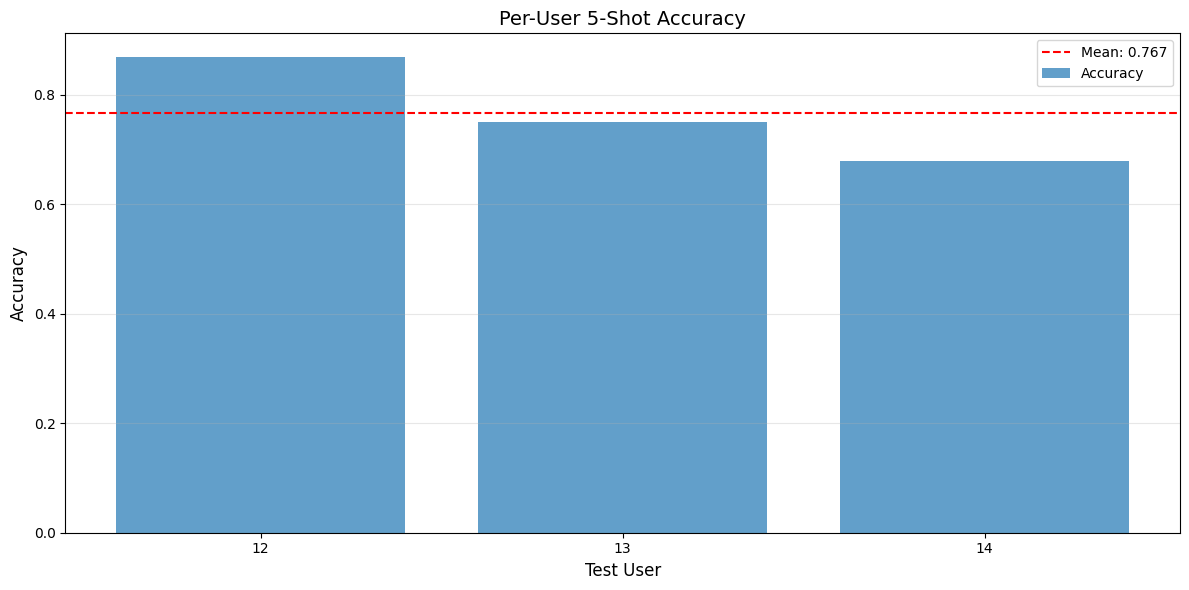

Displayed: user_performance_k3.png

FEATURE CALIBRATION / VARIANCE ANALYSIS


,Intra-Class Variance (L2),Inter-Class Variance (L2),Separation Ratio (Inter/Intra)
0,2.1936,4.9782,2.2694



ROBUSTNESS TEST (NOISY QUERY, K=3)
... Testing Robustness: Type=jitter, Level=0.1
    -> Acc: 0.7557, F1: 0.7559
... Testing Robustness: Type=jitter, Level=0.2
    -> Acc: 0.7654, F1: 0.7653
... Testing Robustness: Type=jitter, Level=0.3
    -> Acc: 0.7483, F1: 0.7483
... Testing Robustness: Type=dropout, Level=0.1
    -> Acc: 0.7446, F1: 0.7447
... Testing Robustness: Type=dropout, Level=0.2
    -> Acc: 0.7242, F1: 0.7241
... Testing Robustness: Type=dropout, Level=0.3
    -> Acc: 0.6650, F1: 0.6652
... Testing Robustness: Type=shift, Level=0.1
    -> Acc: 0.7526, F1: 0.7527
... Testing Robustness: Type=shift, Level=0.2
    -> Acc: 0.7413, F1: 0.7414
... Testing Robustness: Type=shift, Level=0.3
    -> Acc: 0.7336, F1: 0.7335

STARTING LEAVE-ONE-SUBJECT-OUT (LOSO) EXPERIMENT
Total Subjects: 14. This will run 14 training sessions.

--- LOSO Run 1/14: Testing on User 1 ---
Meta-Training for User 1...

Episode    0 | Loss: 2.1451 | Train Acc: 0.4909 | Val Acc: 0.0833
10 20 30 40 50 60 7

,User,Accuracy,F1,Precision,Recall
0,1,0.7782,0.7781,0.7791,0.7782
1,2,0.7769,0.7770,0.7784,0.7769
2,3,0.8504,0.8505,0.8509,0.8504
3,4,0.7146,0.7147,0.7155,0.7146
4,5,0.8530,0.8529,0.8535,0.8530
5,6,0.8232,0.8229,0.8232,0.8232
6,7,0.8543,0.8543,0.8551,0.8543
7,8,0.7320,0.7327,0.7343,0.7320
8,9,0.8691,0.8690,0.8692,0.8691
9,10,0.8459,0.8459,0.8463,0.8459



Mean LOSO Accuracy: 0.7959 ± 0.0605

LOSO EXPERIMENT FINAL SUMMARY (K=3)

Overall LOSO Mean Accuracy (14 Users): 0.7959 ± 0.0605
Overall LOSO Mean F1 (14 Users): 0.7959

COMPREHENSIVE SUMMARY FOR K-TRAIN = 3

STARTING FULL EXPERIMENT RUN FOR: K-TRAIN = 4-SHOT

BUILDING UNCERTAINTY-AWARE PROTOTYPE NETWORK

MODEL ARCHITECTURE & PERFORMANCE STATS


,Metric,Value
0,Parameters (M),0.40
1,FLOPs (M),4.40
2,Inference Time (ms),10.09



META-TRAINING (K=4, 2000 Episodes)

Episode    0 | Loss: 1.9832 | Train Acc: 0.5800 | Val Acc: 0.0844
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 
Episode  200 | Loss: 0.5145 | Train Acc: 0.7889 | Val Acc: 0.8025
210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 
Episode  400 | Loss: 0.1209 | Train Acc: 0.9630 | Val Acc: 0.8117
410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 
Episode  600 | Loss: 0.2466 | Train Acc: 0.9133 | Val Acc: 0.8572
610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 
Episode  800 | Loss: 0.0997 | Train Acc: 0.9889 | Val Acc: 0.8592
810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 
Episode 1000 | Loss: 0.2218 | Train Acc: 0.9167 | Val Acc: 0.8647
1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 
Episode 1200 | Loss: 0.1310 | Train Acc: 0.9524 | Val Acc: 0.8711
121

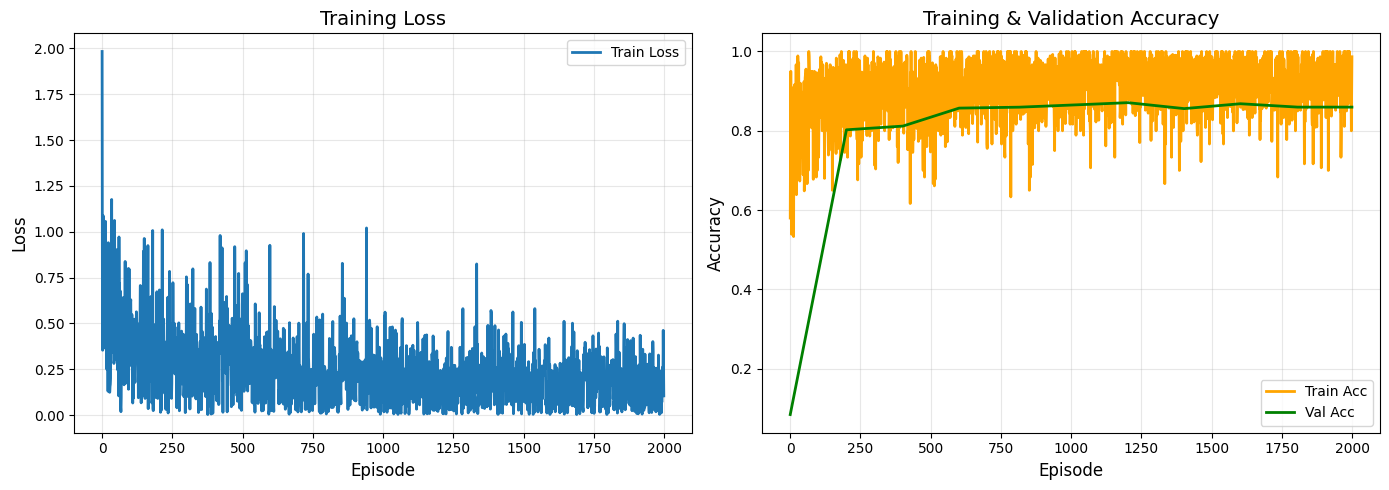

Displayed: learning_curves_k4.png

META-TESTING: 12-WAY, 4-SHOT PERFORMANCE (CROSS-DOMAIN)

OVERALL RESULTS (LSSO SPLIT):


,Metric,Value
0,Accuracy,0.7761
1,F1-Score (macro),0.7761
2,Precision (macro),0.7763
3,Recall (macro),0.7761



PER-CLASS ACCURACY (LSSO SPLIT):


,Class,Accuracy
0,Walking Forward,0.7967
1,Walking Left,0.8027
2,Walking Right,0.7530
3,Walking Upstairs,0.7627
4,Walking Downstairs,0.7723
5,Running Forward,0.7620
6,Jumping,0.7727
7,Sitting,0.7840
8,Standing,0.7833
9,Sleeping,0.7690


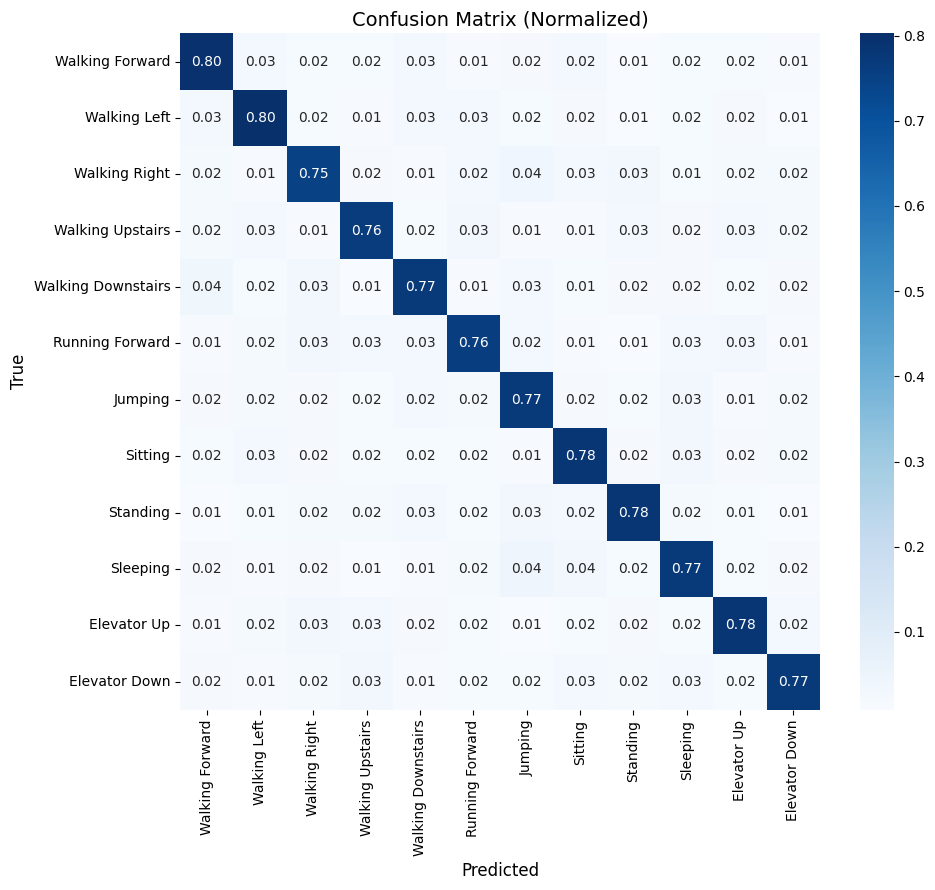


Displayed: cm_k4.png

K-SHOT ABLATION STUDY
Testing 1-shot...
Testing 3-shot...
Testing 5-shot...
Testing 10-shot...
Testing 20-shot...

K-SHOT COMPARISON:


,K-Shot,Accuracy,F1,Precision,Recall
0,1,0.7155,0.7153,0.7155,0.7155
1,3,0.7847,0.7847,0.7853,0.7847
2,5,0.7797,0.7797,0.7800,0.7797
3,10,0.7987,0.7986,0.7987,0.7987
4,20,0.7896,0.7896,0.7900,0.7896


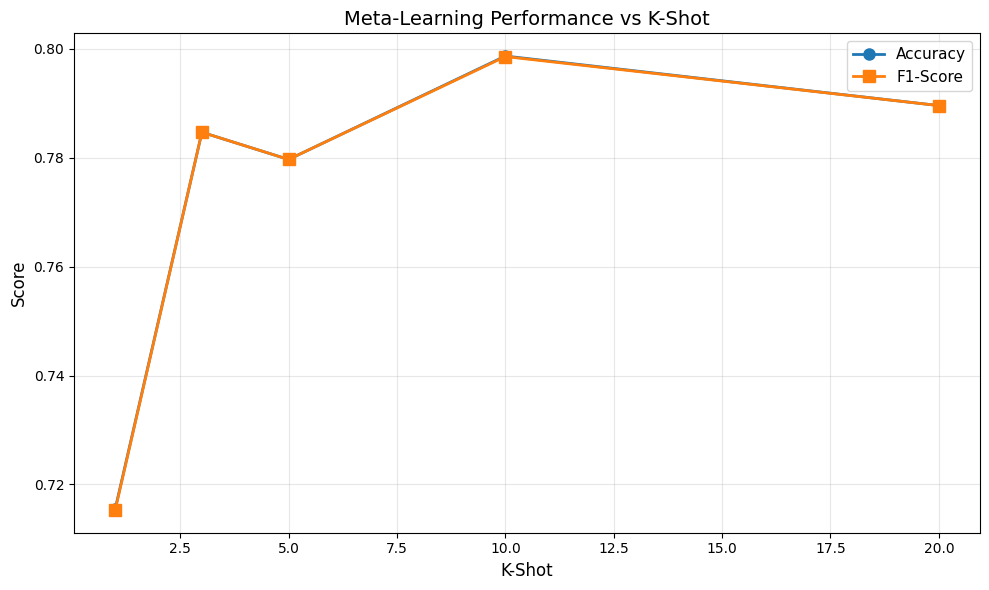


Displayed: kshot_comparison_k4.png

N-WAY ABLATION STUDY (K=4)
Testing 4-way...
Testing 6-way...
Testing 8-way...
Testing 10-way...
Testing 12-way...

N-WAY COMPARISON:


,N-Way,Accuracy,F1,Precision,Recall
0,4,0.9260,0.9260,0.9261,0.9260
1,6,0.8668,0.8670,0.8675,0.8668
2,8,0.8414,0.8414,0.8415,0.8414
3,10,0.8056,0.8054,0.8057,0.8056
4,12,0.7908,0.7907,0.7914,0.7908



QUERY SET SIZE ABLATION (K=4)
Testing query=5...
Testing query=10...
Testing query=15...
Testing query=20...
Testing query=25...

QUERY SIZE COMPARISON:


,Query Size (q),Accuracy,F1,Precision,Recall
0,5,0.7908,0.7908,0.7909,0.7908
1,10,0.7837,0.7837,0.7841,0.7837
2,15,0.7923,0.7922,0.7928,0.7923
3,20,0.7887,0.7887,0.7890,0.7887
4,25,0.7880,0.7882,0.7887,0.7880



PER-USER PERSONALIZATION (ON TEST SET, K=4)


,User,Accuracy,F1,Precision,Recall
0,12,0.8583,0.8583,0.8587,0.8583
1,13,0.7722,0.7716,0.7732,0.7722
2,14,0.7169,0.7166,0.7180,0.7169



Mean User Accuracy (Test Set): 0.7825 ± 0.0582


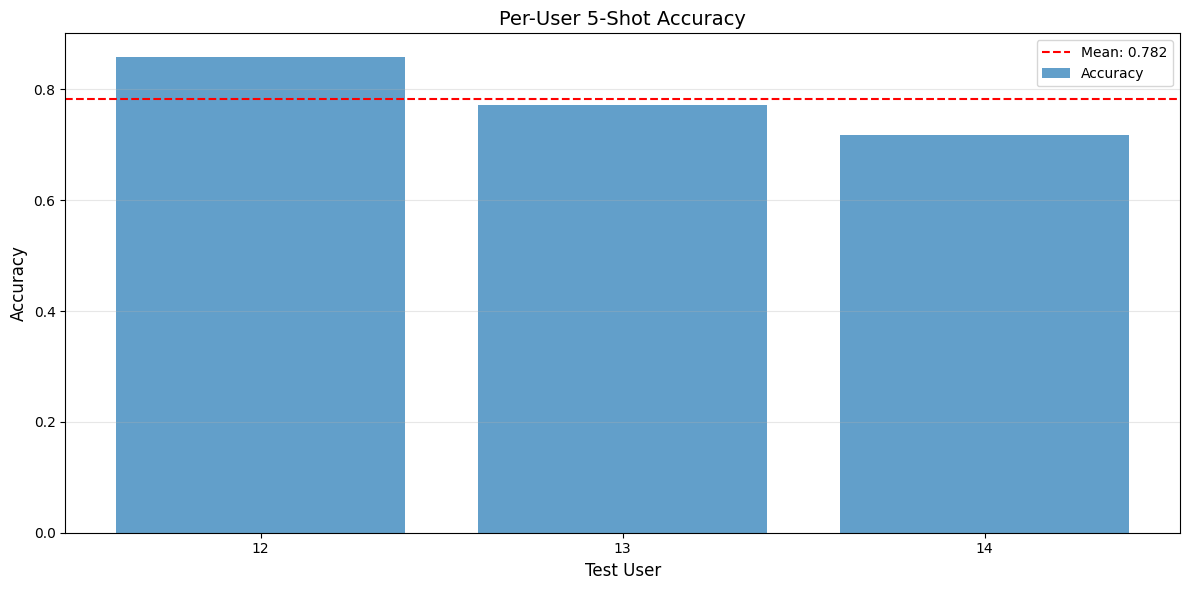

Displayed: user_performance_k4.png

FEATURE CALIBRATION / VARIANCE ANALYSIS


,Intra-Class Variance (L2),Inter-Class Variance (L2),Separation Ratio (Inter/Intra)
0,2.3585,5.2762,2.2371



ROBUSTNESS TEST (NOISY QUERY, K=4)
... Testing Robustness: Type=jitter, Level=0.1
    -> Acc: 0.7733, F1: 0.7733
... Testing Robustness: Type=jitter, Level=0.2
    -> Acc: 0.7714, F1: 0.7715
... Testing Robustness: Type=jitter, Level=0.3
    -> Acc: 0.7467, F1: 0.7467
... Testing Robustness: Type=dropout, Level=0.1
    -> Acc: 0.7732, F1: 0.7731
... Testing Robustness: Type=dropout, Level=0.2
    -> Acc: 0.7323, F1: 0.7323
... Testing Robustness: Type=dropout, Level=0.3
    -> Acc: 0.6753, F1: 0.6753
... Testing Robustness: Type=shift, Level=0.1
    -> Acc: 0.7829, F1: 0.7829
... Testing Robustness: Type=shift, Level=0.2
    -> Acc: 0.7679, F1: 0.7680
... Testing Robustness: Type=shift, Level=0.3
    -> Acc: 0.7544, F1: 0.7544

STARTING LEAVE-ONE-SUBJECT-OUT (LOSO) EXPERIMENT
Total Subjects: 14. This will run 14 training sessions.

--- LOSO Run 1/14: Testing on User 1 ---
Meta-Training for User 1...

Episode    0 | Loss: 1.8168 | Train Acc: 0.4067 | Val Acc: 0.0803
10 20 30 40 50 60 7

,User,Accuracy,F1,Precision,Recall
0,1,0.8000,0.7999,0.8001,0.8000
1,2,0.7451,0.7458,0.7477,0.7451
2,3,0.8743,0.8742,0.8743,0.8743
3,4,0.7342,0.7341,0.7353,0.7342
4,5,0.8343,0.8341,0.8343,0.8343
5,6,0.8316,0.8315,0.8318,0.8316
6,7,0.8564,0.8565,0.8567,0.8564
7,8,0.8093,0.8093,0.8097,0.8093
8,9,0.8412,0.8413,0.8418,0.8412
9,10,0.8617,0.8616,0.8621,0.8617



Mean LOSO Accuracy: 0.8082 ± 0.0581

LOSO EXPERIMENT FINAL SUMMARY (K=4)

Overall LOSO Mean Accuracy (14 Users): 0.8082 ± 0.0581
Overall LOSO Mean F1 (14 Users): 0.8082

COMPREHENSIVE SUMMARY FOR K-TRAIN = 4

STARTING FULL EXPERIMENT RUN FOR: K-TRAIN = 5-SHOT

BUILDING UNCERTAINTY-AWARE PROTOTYPE NETWORK

MODEL ARCHITECTURE & PERFORMANCE STATS


,Metric,Value
0,Parameters (M),0.40
1,FLOPs (M),4.40
2,Inference Time (ms),10.19



META-TRAINING (K=5, 2000 Episodes)

Episode    0 | Loss: 1.4970 | Train Acc: 0.6083 | Val Acc: 0.0833
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 
Episode  200 | Loss: 0.3726 | Train Acc: 0.9048 | Val Acc: 0.8308
210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 
Episode  400 | Loss: 0.3872 | Train Acc: 0.8722 | Val Acc: 0.8142
410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 
Episode  600 | Loss: 0.0136 | Train Acc: 1.0000 | Val Acc: 0.8619
610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 
Episode  800 | Loss: 0.2660 | Train Acc: 0.8611 | Val Acc: 0.8136
810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 
Episode 1000 | Loss: 0.2740 | Train Acc: 0.8733 | Val Acc: 0.8436
1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 
Episode 1200 | Loss: 0.2297 | Train Acc: 0.8952 | Val Acc: 0.8494
121

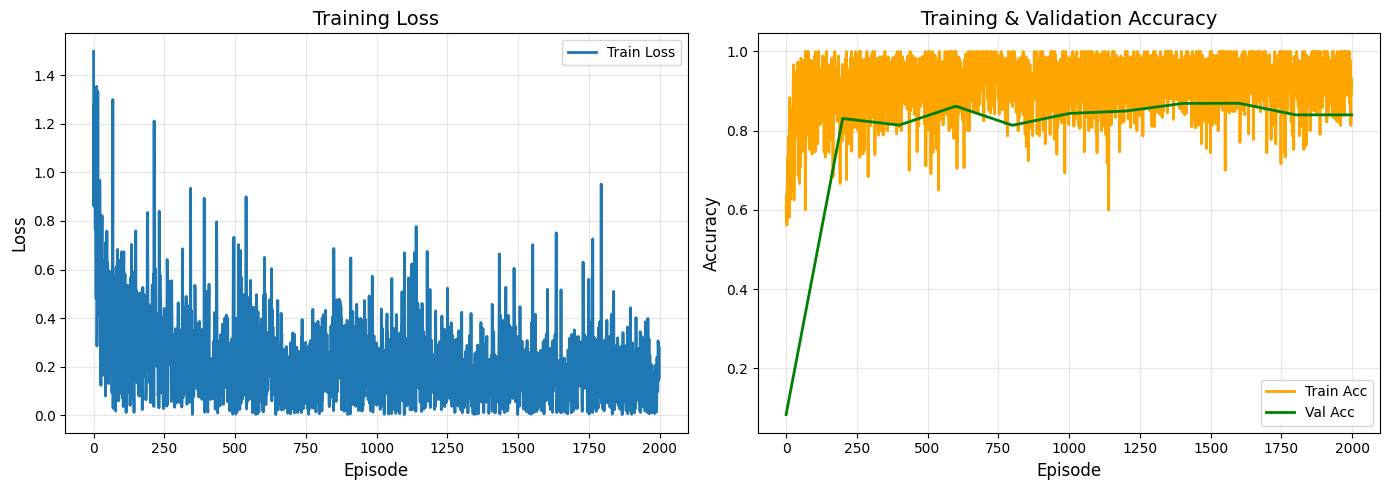

Displayed: learning_curves_k5.png

META-TESTING: 12-WAY, 5-SHOT PERFORMANCE (CROSS-DOMAIN)

OVERALL RESULTS (LSSO SPLIT):


,Metric,Value
0,Accuracy,0.7639
1,F1-Score (macro),0.7637
2,Precision (macro),0.7639
3,Recall (macro),0.7639



PER-CLASS ACCURACY (LSSO SPLIT):


,Class,Accuracy
0,Walking Forward,0.7130
1,Walking Left,0.7473
2,Walking Right,0.7550
3,Walking Upstairs,0.7770
4,Walking Downstairs,0.7953
5,Running Forward,0.7737
6,Jumping,0.7643
7,Sitting,0.7717
8,Standing,0.7223
9,Sleeping,0.8217


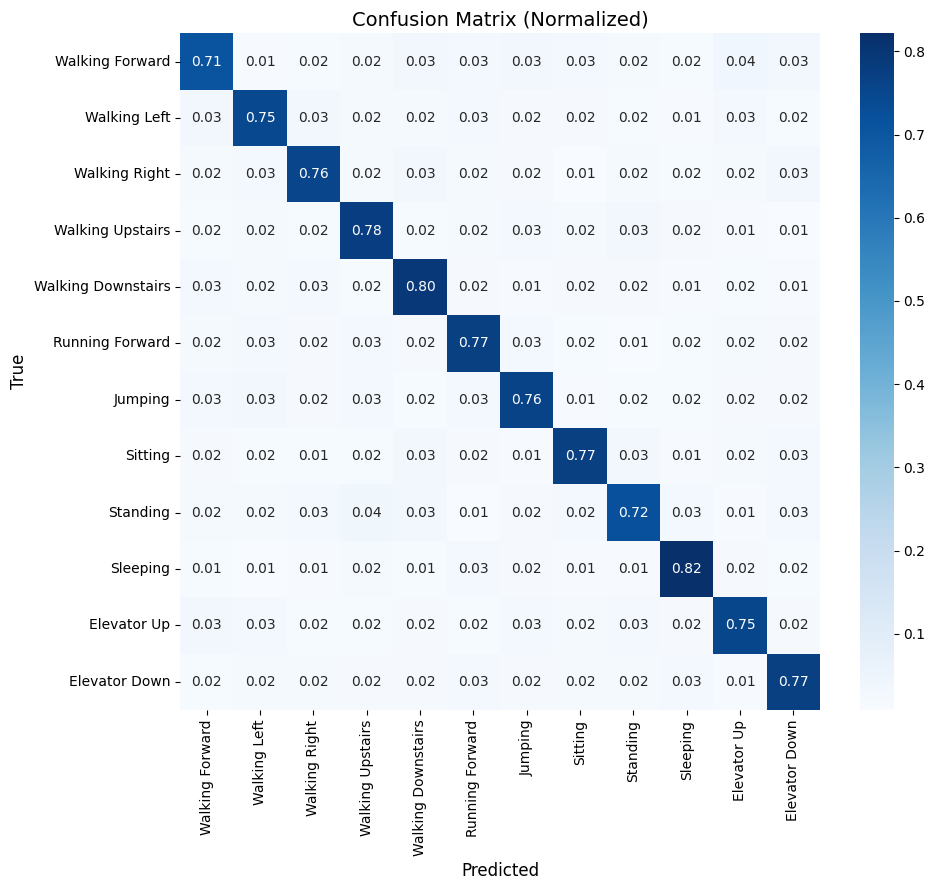


Displayed: cm_k5.png

K-SHOT ABLATION STUDY
Testing 1-shot...
Testing 3-shot...
Testing 5-shot...
Testing 10-shot...
Testing 20-shot...

K-SHOT COMPARISON:


,K-Shot,Accuracy,F1,Precision,Recall
0,1,0.6795,0.6798,0.6808,0.6795
1,3,0.7637,0.7636,0.7638,0.7637
2,5,0.7577,0.7577,0.7579,0.7577
3,10,0.7698,0.7695,0.7699,0.7698
4,20,0.7689,0.7688,0.7690,0.7689


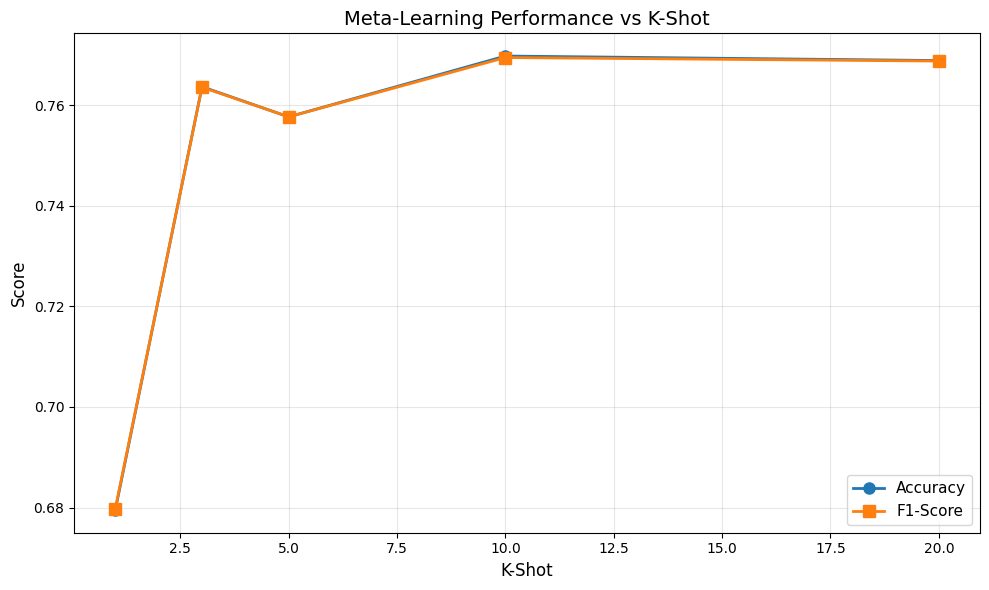


Displayed: kshot_comparison_k5.png

N-WAY ABLATION STUDY (K=5)
Testing 4-way...
Testing 6-way...
Testing 8-way...
Testing 10-way...
Testing 12-way...

N-WAY COMPARISON:


,N-Way,Accuracy,F1,Precision,Recall
0,4,0.9008,0.9008,0.9012,0.9008
1,6,0.8863,0.8864,0.8867,0.8863
2,8,0.8144,0.8143,0.8144,0.8144
3,10,0.7831,0.7831,0.7834,0.7831
4,12,0.7349,0.7346,0.7348,0.7349



QUERY SET SIZE ABLATION (K=5)
Testing query=5...
Testing query=10...
Testing query=15...
Testing query=20...
Testing query=25...

QUERY SIZE COMPARISON:


,Query Size (q),Accuracy,F1,Precision,Recall
0,5,0.7627,0.7626,0.7633,0.7627
1,10,0.7649,0.7649,0.7653,0.7649
2,15,0.7392,0.7390,0.7393,0.7392
3,20,0.7458,0.7460,0.7467,0.7458
4,25,0.7525,0.7523,0.7525,0.7525



PER-USER PERSONALIZATION (ON TEST SET, K=5)


,User,Accuracy,F1,Precision,Recall
0,12,0.8457,0.8450,0.8459,0.8457
1,13,0.7757,0.7757,0.7769,0.7757
2,14,0.6291,0.6282,0.6288,0.6291



Mean User Accuracy (Test Set): 0.7502 ± 0.0903


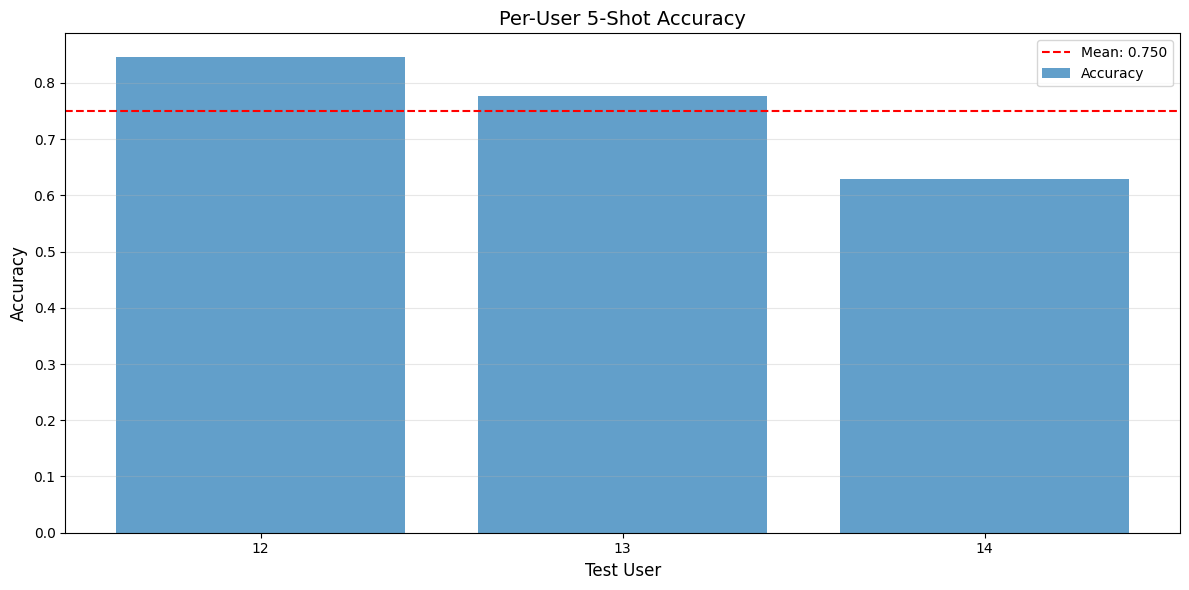

Displayed: user_performance_k5.png

FEATURE CALIBRATION / VARIANCE ANALYSIS


,Intra-Class Variance (L2),Inter-Class Variance (L2),Separation Ratio (Inter/Intra)
0,2.8574,4.4719,1.5650



ROBUSTNESS TEST (NOISY QUERY, K=5)
... Testing Robustness: Type=jitter, Level=0.1
    -> Acc: 0.7626, F1: 0.7627
... Testing Robustness: Type=jitter, Level=0.2
    -> Acc: 0.7586, F1: 0.7586
... Testing Robustness: Type=jitter, Level=0.3
    -> Acc: 0.7259, F1: 0.7259
... Testing Robustness: Type=dropout, Level=0.1
    -> Acc: 0.7259, F1: 0.7259
... Testing Robustness: Type=dropout, Level=0.2
    -> Acc: 0.7378, F1: 0.7378
... Testing Robustness: Type=dropout, Level=0.3
    -> Acc: 0.7024, F1: 0.7025
... Testing Robustness: Type=shift, Level=0.1
    -> Acc: 0.7506, F1: 0.7504
... Testing Robustness: Type=shift, Level=0.2
    -> Acc: 0.7297, F1: 0.7296
... Testing Robustness: Type=shift, Level=0.3
    -> Acc: 0.7241, F1: 0.7241

STARTING LEAVE-ONE-SUBJECT-OUT (LOSO) EXPERIMENT
Total Subjects: 14. This will run 14 training sessions.

--- LOSO Run 1/14: Testing on User 1 ---
Meta-Training for User 1...

Episode    0 | Loss: 1.8182 | Train Acc: 0.4242 | Val Acc: 0.0842
10 20 30 40 50 60 7

,User,Accuracy,F1,Precision,Recall
0,1,0.8298,0.8297,0.8300,0.8298
1,2,0.7361,0.7358,0.7365,0.7361
2,3,0.8690,0.8691,0.8697,0.8690
3,4,0.7067,0.7066,0.7068,0.7067
4,5,0.8401,0.8401,0.8402,0.8401
5,6,0.8417,0.8415,0.8424,0.8417
6,7,0.8616,0.8614,0.8618,0.8616
7,8,0.7869,0.7866,0.7875,0.7869
8,9,0.8751,0.8751,0.8756,0.8751
9,10,0.8622,0.8623,0.8636,0.8622



Mean LOSO Accuracy: 0.8034 ± 0.0762

LOSO EXPERIMENT FINAL SUMMARY (K=5)

Overall LOSO Mean Accuracy (14 Users): 0.8034 ± 0.0762
Overall LOSO Mean F1 (14 Users): 0.8033

COMPREHENSIVE SUMMARY FOR K-TRAIN = 5

===== ALL EXPERIMENTS COMPLETE: FINAL COMPREHENSIVE RESULTS =====


,Metric,Train K=1-Shot,Train K=2-Shot,Train K=3-Shot,Train K=4-Shot,Train K=5-Shot
0,Experiment,Train K=1-Shot,Train K=2-Shot,Train K=3-Shot,Train K=4-Shot,Train K=5-Shot
1,Parameters (M),0.40,0.40,0.40,0.40,0.40
2,FLOPs (M),4.40,4.40,4.40,4.40,4.40
3,Inference Time (ms),11.45,9.50,9.78,10.09,10.19
4,--- LSSO Test (Users 12-14) ---,---,---,---,---,---
5,Accuracy (12W-1S),0.6776,0.6891,0.6896,0.7155,0.6795
6,F1 (12W-1S),0.6776,0.6892,0.6895,0.7153,0.6798
7,--- Few-Shot Scaling (LSSO) ---,---,---,---,---,---
8,Accuracy (12W-1S),0.6964,0.6891,0.6896,0.7155,0.6795
9,F1 (12W-1S),0.6963,0.6892,0.6895,0.7153,0.6798


In [9]:
import os
import random
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from thop import profile
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import re
import scipy.io as scio

ACTIVITIES = {
    0: 'Walking Forward',
    1: 'Walking Left',
    2: 'Walking Right',
    3: 'Walking Upstairs',
    4: 'Walking Downstairs',
    5: 'Running Forward',
    6: 'Jumping',
    7: 'Sitting',
    8: 'Standing',
    9: 'Sleeping',
    10: 'Elevator Up',
    11: 'Elevator Down'
}

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def compute_mean_std(X):
    X = X.astype(np.float32)
    mean = X.mean(axis=(0, 2), keepdims=True)
    std  = X.std(axis=(0, 2), keepdims=True) + 1e-8
    return mean, std

def augment_data(x_batch, jitter_sigma=0.03, scale_max=0.1):
    jitter = torch.randn_like(x_batch) * jitter_sigma
    x_batch = x_batch + jitter

    scale = 1.0 + (torch.rand(x_batch.shape[0], 1, 1, device=x_batch.device) - 0.5) * 2 * scale_max
    x_batch = x_batch * scale

    return x_batch

def compute_model_stats(encoder, input_shape=(1, 6, 100)):
    device = next(encoder.parameters()).device
    macs, params = profile(encoder, inputs=(torch.randn(*input_shape).to(device),), verbose=False)
    return params/1e6, macs/1e6

def measure_inference_time(model, n_way, sz=(1, 6, 100), dev='cuda', runs=100, warm=10):
    model.eval()
    x_q = torch.randn(sz, device=dev)
    x_s = torch.randn((n_way*5,) + sz[1:], device=dev)
    y_s = torch.tensor(np.repeat(range(n_way), 5), device=dev)

    with torch.no_grad():
        for _ in range(warm):
            _, _ = model(x_q, x_s, y_s, n_way)
    torch.cuda.synchronize() if dev=='cuda' else None
    t0 = time.time()
    with torch.no_grad():
        for _ in range(runs):
            _, _ = model(x_q, x_s, y_s, n_way)
    torch.cuda.synchronize() if dev=='cuda' else None
    return (time.time()-t0)/runs*1000

def plot_confusion_matrix(cm, labels):
    cmn = cm.astype('float')/cm.sum(axis=1)[:,None]
    df = pd.DataFrame(cmn, index=labels, columns=labels)
    plt.figure(figsize=(10,9))
    sns.heatmap(df, annot=True, fmt='.2f', cmap='Blues', cbar=True)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title('Confusion Matrix (Normalized)', fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_learning_curves(train_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(train_losses, linewidth=2, label='Train Loss')
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training Loss', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(train_accs, linewidth=2, color='orange', label='Train Acc')
    ax2.plot(val_accs, linewidth=2, color='green', label='Val Acc')
    ax2.set_xlabel('Episode', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Training & Validation Accuracy', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_kshot_comparison(shot_results):
    plt.figure(figsize=(10, 6))
    plt.plot([r['K'] for r in shot_results], [r['Accuracy'] for r in shot_results],
             marker='o', linewidth=2, markersize=8, label='Accuracy')
    plt.plot([r['K'] for r in shot_results], [r['F1'] for r in shot_results],
             marker='s', linewidth=2, markersize=8, label='F1-Score')
    plt.xlabel('K-Shot', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Meta-Learning Performance vs K-Shot', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_user_performance(per_user_df):
    plt.figure(figsize=(12, 6))
    x = range(len(per_user_df))
    plt.bar(x, per_user_df['Accuracy'], alpha=0.7, label='Accuracy')
    plt.axhline(y=per_user_df['Accuracy'].mean(), color='r', linestyle='--',
                label=f'Mean: {per_user_df["Accuracy"].mean():.3f}')
    plt.xlabel('Test User', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Per-User 5-Shot Accuracy', fontsize=14)
    plt.xticks(x, per_user_df['User'])
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

class HARDataset(Dataset):
    def __init__(self, X, y, norm=True):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        if norm:
            self.mean = self.X.mean(axis=(0,2), keepdims=True)
            self.std = self.X.std(axis=(0,2), keepdims=True) + 1e-8
            self.X = (self.X - self.mean)/self.std
        else:
            self.mean, self.std = None, None

    def set_stats(self, mean, std):
        self.mean, self.std = mean, std
        self.X = (self.X - self.mean)/self.std

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), int(self.y[i])

def slide_window(array, w_s, stride):
    x = []
    times = (array.shape[0] - w_s) // stride + 1
    i = 0
    for i in range(times):
        x.append(array[stride*i: stride*i+w_s])

    if stride*i+w_s < array.shape[0]-1:
        x.append(array[-w_s:])
    return x

def load_uschad_data(path, w_s=100, stride=50):
    result = []
    subject_ids = []
    labels = []

    if not os.path.exists(path):
        return None, None, None, None

    subject_list = os.listdir(path)
    subject_list = [subject for subject in subject_list if subject.find('Subject') != -1]
    subject_list = sorted(subject_list)

    if not subject_list:
        return None, None, None, None

    print(f"Loading USC-HAD: Found {len(subject_list)} subjects. (w_s={w_s}, stride={stride})")

    original_cwd = os.getcwd()
    try:
        os.chdir(path)

        for i, subject in enumerate(subject_list):
            if not os.path.isdir(subject):
                continue

            subject_num_match = re.findall(r'(\d+)', subject)
            if not subject_num_match:
                continue
            subject_num = int(subject_num_match[0])

            mat_list = os.listdir(subject)
            os.chdir(subject)

            for mat in mat_list:
                if not mat.endswith('.mat'):
                    continue

                activity_num_match = re.findall(r'a(\d+)', mat)
                if not activity_num_match:
                    continue

                category = int(activity_num_match[0]) - 1
                if category not in ACTIVITIES:
                    continue

                content = scio.loadmat(mat)['sensor_readings']

                x = slide_window(content, w_s, stride)

                result.extend(x)
                subject_ids.extend([subject_num] * len(x))
                labels.extend([category] * len(x))

            os.chdir('../')

    except Exception as e:
        print(f"Error loading data: {e}")
        os.chdir(original_cwd)
        return None, None, None, None

    os.chdir(original_cwd)

    if not result:
        return None, None, None, None

    data = np.array(result, dtype=np.float32)
    data = np.transpose(data, (0, 2, 1))

    activity_labels = [ACTIVITIES[i] for i in range(len(ACTIVITIES))]

    return data, np.array(labels, dtype=int), np.array(subject_ids, dtype=int), activity_labels

class CompactEncoder(nn.Module):
    def __init__(self, in_channels=9, embed_dim=128):
        super().__init__()
        self.stage1 = self._make_stage(in_channels, 32, stride=2)
        self.stage2 = self._make_stage(32, 64, stride=2)
        self.stage3 = self._make_stage(64, 128, stride=2)
        self.stage4 = self._make_stage(128, embed_dim, stride=2)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def _make_stage(self, in_ch, out_ch, stride=1):
        return nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=5, stride=stride, padding=2),
            nn.BatchNorm1d(out_ch),
            nn.GELU(),
            nn.Conv1d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.GELU(),
            nn.Conv1d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.GELU()
        )

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.pool(x).flatten(1)
        return x

class UncertaintyEncoder(nn.Module):
    def __init__(self, base_cnn, feature_dim):
        super().__init__()
        self.base = base_cnn
        self.fc_mu = nn.Linear(feature_dim, feature_dim)
        self.fc_logvar = nn.Linear(feature_dim, feature_dim)

    def forward(self, x):
        feat = self.base(x)
        mu = self.fc_mu(feat)
        logvar = self.fc_logvar(feat)
        return mu, logvar

class PrototypeNetwork(nn.Module):
    def __init__(self, encoder, temperature=1.0):
        super().__init__()
        self.encoder = encoder
        self.temperature = temperature

        feature_dim = encoder.fc_mu.in_features

        self.attention = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2),
            nn.ReLU(),
            nn.Linear(feature_dim // 2, 1)
        )
        self.adapter = nn.Sequential(
            nn.Linear(feature_dim * 2, feature_dim),
            nn.ReLU(),
            nn.Linear(feature_dim, feature_dim)
        )

    def compute_prototypes(self, support_mu, support_logvar, support_y, n_way):
        embed_dim = support_mu.size(1)
        prototypes_mu = []
        prototypes_sigma = []

        for c in range(n_way):
            mask = (support_y == c)
            if mask.sum() > 0:
                mu_c = support_mu[mask]
                logvar_c = support_logvar[mask]

                attn_w = F.softmax(self.attention(mu_c), dim=0)

                sigma_c_sq = torch.exp(logvar_c)
                var_w = 1.0 / (sigma_c_sq + 1e-6)

                weight = attn_w * var_w

                weighted_mu = (weight * mu_c).sum(0) / weight.sum(0)

                weighted_sigma_sq = 1.0 / weight.sum(0)
                weighted_sigma = torch.sqrt(weighted_sigma_sq)

                prototypes_mu.append(weighted_mu)
                prototypes_sigma.append(weighted_sigma)
            else:
                prototypes_mu.append(torch.zeros(embed_dim, device=support_mu.device))
                prototypes_sigma.append(torch.ones(embed_dim, device=support_mu.device))

        return torch.stack(prototypes_mu), torch.stack(prototypes_sigma)

    def forward(self, query_x, support_x, support_y, n_way):
        support_mu, support_logvar = self.encoder(support_x)
        query_mu, query_logvar = self.encoder(query_x)

        prototypes_mu, prototypes_sigma = self.compute_prototypes(support_mu, support_logvar, support_y, n_way)

        query_sigma = torch.exp(0.5 * query_logvar)

        n_query = query_mu.size(0)

        query_mu_expanded = query_mu.unsqueeze(1).expand(-1, n_way, -1)
        query_sigma_expanded = query_sigma.unsqueeze(1).expand(-1, n_way, -1)

        proto_mu_expanded = prototypes_mu.unsqueeze(0).expand(n_query, -1, -1)
        proto_sigma_expanded = prototypes_sigma.unsqueeze(0).expand(n_query, -1, -1)

        cat_input = torch.cat([query_mu_expanded, proto_mu_expanded], dim=-1)
        delta = self.adapter(cat_input)
        adapted_mu = proto_mu_expanded + delta

        mu_diff_sq = (query_mu_expanded - adapted_mu)**2
        sigma_sum_sq = query_sigma_expanded**2 + proto_sigma_expanded**2 + 1e-6
        dist = (mu_diff_sq / sigma_sum_sq).sum(dim=-1)

        logits = -dist / self.temperature

        all_mu = torch.cat([support_mu, query_mu], dim=0)
        all_logvar = torch.cat([support_logvar, query_logvar], dim=0)
        kl_div = -0.5 * torch.sum(1 + all_logvar - all_mu.pow(2) - all_logvar.exp(), dim=1).mean()

        return logits, kl_div


def create_episodes(users_data, n_way=6, k_shot=5, q_query=15, total_classes=6):
    if not users_data:
        return (torch.empty(0), torch.empty(0), torch.empty(0), torch.empty(0))

    for _ in range(50):
        user = random.choice(users_data)
        data = user['data']
        labels = user['labels']
        unique_cls = np.unique(labels)

        if len(unique_cls) < n_way:
            continue

        chosen_classes = np.random.choice(unique_cls, n_way, replace=False)
        support_x, support_y, query_x, query_y = [], [], [], []

        valid_episode = True
        for new_c, original_c in enumerate(chosen_classes):
            idxs = np.where(labels == original_c)[0]
            if len(idxs) < k_shot + q_query:
                valid_episode = False
                break

            np.random.shuffle(idxs)
            s_idx = idxs[:k_shot]
            q_idx = idxs[k_shot:k_shot+q_query]

            support_x.extend([data[i] for i in s_idx])
            support_y.extend([new_c] * k_shot)
            query_x.extend([data[i] for i in q_idx])
            query_y.extend([new_c] * q_query)

        if valid_episode:
            if not support_x or not query_x:
                continue
            return (torch.stack(support_x), torch.tensor(support_y),
                    torch.stack(query_x), torch.tensor(query_y))

    return (torch.empty(0), torch.empty(0), torch.empty(0), torch.empty(0))

def meta_train(model, optimizer, train_users, val_users, n_way_range, k_shot=5, q_query=15,
               episodes=2000, log_every=100, val_every=200, kl_weight=0.001, total_classes=6):
    model.train()
    train_losses, train_accs, val_accs = [], [], []


    for ep in range(episodes):
        if (ep+1) % 10 == 0 :
            print(ep+1, end=' ')

        n_way = random.randint(n_way_range[0], n_way_range[1])

        support_x, support_y, query_x, query_y = create_episodes(train_users, n_way, k_shot, q_query, total_classes=total_classes)
        if support_x.size(0) == 0:
            continue

        support_x = augment_data(support_x)
        query_x = augment_data(query_x)

        support_x, support_y = support_x.cuda(), support_y.cuda()
        query_x, query_y = query_x.cuda(), query_y.cuda()

        logits, kl_div = model(query_x, support_x, support_y, n_way)
        ce_loss = F.cross_entropy(logits, query_y)
        loss = ce_loss + kl_weight * kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (logits.argmax(1) == query_y).float().mean().item()
        train_losses.append(loss.item())
        train_accs.append(acc)

        if ep % val_every == 0:
            val_acc = meta_validate(model, val_users, k_shot, n_way_range[1], trials=20, total_classes=total_classes)
            val_accs.append(val_acc)
            if ep % log_every == 0:
                print ()
                print(f"Episode {ep:4d} | Loss: {loss.item():.4f} | Train Acc: {acc:.4f} | Val Acc: {val_acc:.4f}")
        elif ep % log_every == 0:
            print ()
            print(f"Episode {ep:4d} | Loss: {loss.item():.4f} | Train Acc: {acc:.4f}")

    val_episodes = list(range(0, episodes, val_every))
    if len(val_accs) < len(val_episodes) and len(val_accs) > 0:
        val_accs.extend([val_accs[-1]] * (len(val_episodes) - len(val_accs)))
    elif len(val_accs) == 0:
        val_accs = [0.0] * len(val_episodes)

    return train_losses, train_accs, val_accs, val_episodes

def meta_validate(model, val_users, k_shot=5, n_way=6, trials=20, total_classes=6):
    model.eval()
    correct, total = 0, 0
    for _ in range(trials):
        support_x, support_y, query_x, query_y = create_episodes(val_users, n_way, k_shot, 15, total_classes=total_classes)
        if support_x.size(0) == 0:
            continue
        support_x, support_y = support_x.cuda(), support_y.cuda()
        query_x, query_y = query_x.cuda(), query_y.cuda()
        with torch.no_grad():
            logits, _ = model(query_x, support_x, support_y, n_way)
            preds = logits.argmax(1)
            correct += (preds == query_y).sum().item()
            total += len(query_y)
    model.train()
    return correct / total if total > 0 else 0.0

def meta_test(model, test_users, k_shot=5, n_way=6, q_query=15, trials=100, total_classes=6):
    model.eval()
    all_preds, all_trues = [], []

    for _ in range(trials):
        support_x, support_y, query_x, query_y = create_episodes(test_users, n_way, k_shot, q_query, total_classes=total_classes)
        if support_x.size(0) == 0:
            continue
        support_x, support_y = support_x.cuda(), support_y.cuda()
        query_x, query_y = query_x.cuda(), query_y.cuda()

        with torch.no_grad():
            logits, _ = model(query_x, support_x, support_y, n_way)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_trues.extend(query_y.cpu().numpy())

    if not all_trues:
        return 0, 0, 0, 0, np.zeros((n_way, n_way)), [], [], [0.0]*n_way

    acc = accuracy_score(all_trues, all_preds)
    f1 = f1_score(all_trues, all_preds, average='macro', zero_division=0)
    prec = precision_score(all_trues, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_trues, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_trues, all_preds, labels=range(n_way))

    per_class_acc = []
    for c in range(n_way):
        mask = np.array(all_trues) == c
        if mask.sum() > 0:
            class_acc = accuracy_score(np.array(all_trues)[mask], np.array(all_preds)[mask])
            per_class_acc.append(class_acc)
        else:
            per_class_acc.append(0.0)

    return acc, f1, prec, rec, cm, all_preds, all_trues, per_class_acc

def prepare_users(X, y, sub, subs, mean, std):
    users = []
    for uid in subs:
        mask = (sub == uid)
        user_data = X[mask]
        user_labels = y[mask]
        user_dataset = HARDataset(user_data, user_labels, norm=False)
        user_dataset.set_stats(mean, std)

        if len(user_dataset) > 0:
            users.append({
                'data': torch.stack([user_dataset[i][0] for i in range(len(user_dataset))]),
                'labels': user_labels,
                'id': uid
            })
    return users

def run_loso_experiment(X_raw, y_raw, sub_raw, unique_subs, n_way=6, k_shot=5, q_query=15, episodes=2000):
    print("\n" + "=" * 60)
    print("STARTING LEAVE-ONE-SUBJECT-OUT (LOSO) EXPERIMENT")
    print(f"Total Subjects: {len(unique_subs)}. This will run {len(unique_subs)} training sessions.")
    print("=" * 60)

    loso_results = []
    total_classes_loso = len(np.unique(y_raw))

    n_way_range_loso = (max(2, n_way - 2), n_way)

    for i in range(len(unique_subs)):
        test_sub_id = [unique_subs[i]]
        val_sub_id = [unique_subs[(i + 1) % len(unique_subs)]]

        train_sub_ids_indices = [j for j in range(len(unique_subs)) if j != i and j != (i + 1) % len(unique_subs)]
        train_sub_ids = unique_subs[train_sub_ids_indices]


        print(f"\n--- LOSO Run {i+1}/{len(unique_subs)}: Testing on User {test_sub_id[0]} ---")

        train_mask_loso = np.isin(sub_raw, train_sub_ids)
        val_mask_loso = np.isin(sub_raw, val_sub_id)
        test_mask_loso = np.isin(sub_raw, test_sub_id)

        X_train_loso, y_train_loso, sub_train_loso = X_raw[train_mask_loso], y_raw[train_mask_loso], sub_raw[train_mask_loso]
        X_val_loso, y_val_loso, sub_val_loso = X_raw[val_mask_loso], y_raw[val_mask_loso], sub_raw[val_mask_loso]
        X_test_loso, y_test_loso, sub_test_loso = X_raw[test_mask_loso], y_raw[test_mask_loso], sub_raw[test_mask_loso]

        fold_mean, fold_std = compute_mean_std(X_train_loso)

        train_users_loso = prepare_users(X_train_loso, y_train_loso, sub_train_loso, train_sub_ids, fold_mean, fold_std)
        val_users_loso = prepare_users(X_val_loso, y_val_loso, sub_val_loso, val_sub_id, fold_mean, fold_std)
        test_users_loso = prepare_users(X_test_loso, y_test_loso, sub_test_loso, test_sub_id, fold_mean, fold_std)

        if not test_users_loso or not val_users_loso or not train_users_loso:
            print(f"Skipping User {test_sub_id[0]} due to insufficient data in splits.")
            loso_results.append({
                'User': int(test_sub_id[0]),
                'Accuracy': "N/A",
                'F1': "N/A",
                'Precision': "N/A",
                'Recall': "N/A"
            })
            continue

        input_channels = X_raw.shape[1]
        base_encoder_loso = CompactEncoder(in_channels=input_channels, embed_dim=128).cuda()
        encoder_loso = UncertaintyEncoder(base_encoder_loso, feature_dim=128).cuda()
        model_loso = PrototypeNetwork(encoder_loso, temperature=1.0).cuda()
        optimizer_loso = torch.optim.Adam(model_loso.parameters(), lr=0.001)

        print(f"Meta-Training for User {test_sub_id[0]}...")
        meta_train(
            model_loso, optimizer_loso, train_users_loso, val_users_loso,
            n_way_range=n_way_range_loso, k_shot=k_shot, q_query=q_query,
            episodes=episodes, log_every=500, val_every=500, kl_weight=0.0001,
            total_classes=total_classes_loso
        )

        print(f"Meta-Testing on User {test_sub_id[0]}...")
        acc, f1, prec, rec, _, _, _, _ = meta_test(
            model_loso, test_users_loso, k_shot=k_shot, n_way=n_way, q_query=q_query, trials=50,
            total_classes=total_classes_loso
        )

        loso_results.append({
            'User': int(test_sub_id[0]),
            'Accuracy': f"{acc:.4f}",
            'F1': f"{f1:.4f}",
            'Precision': f"{prec:.4f}",
            'Recall': f"{rec:.4f}"
        })

        del base_encoder_loso, encoder_loso, model_loso, optimizer_loso
        torch.cuda.empty_cache()

    print("\n" + "=" * 60)
    print("LOSO EXPERIMENT RESULTS")
    print("=" * 60)
    loso_df = pd.DataFrame(loso_results)
    display(loso_df)

    numeric_acc = pd.to_numeric(loso_df['Accuracy'], errors='coerce').dropna()
    mean_acc = numeric_acc.mean()
    std_acc = numeric_acc.std()
    print(f"\nMean LOSO Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

    return loso_df

def analyze_feature_space(encoder, test_users, class_names, device='cuda'):
    encoder.eval()
    all_embeds = []
    all_labels = []
    with torch.no_grad():
        for user in test_users:
            data = user['data'].to(device)
            embeds, _ = encoder(data)
            all_embeds.append(embeds.cpu().numpy())
            all_labels.extend(user['labels'])
    all_embeds = np.concatenate(all_embeds, axis=0)
    all_labels = np.array(all_labels)

    n_classes = len(class_names)
    class_centroids = []
    intra_class_dists = []

    for c in range(n_classes):
        mask = (all_labels == c)
        if mask.sum() == 0:
            continue
        class_embeds = all_embeds[mask]
        centroid = np.mean(class_embeds, axis=0)
        class_centroids.append(centroid)

        dists = np.linalg.norm(class_embeds - centroid, axis=1)
        intra_class_dists.append(np.mean(dists))

    intra_class_variance = np.mean(intra_class_dists)

    inter_class_dists = []
    class_centroids = np.array(class_centroids)
    for i in range(len(class_centroids)):
        for j in range(i + 1, len(class_centroids)):
            dist = np.linalg.norm(class_centroids[i] - class_centroids[j])
            inter_class_dists.append(dist)

    inter_class_variance = np.mean(inter_class_dists)

    ratio = inter_class_variance / (intra_class_variance + 1e-6)

    results = {
        'Intra-Class Variance (L2)': f"{intra_class_variance:.4f}",
        'Inter-Class Variance (L2)': f"{inter_class_variance:.4f}",
        'Separation Ratio (Inter/Intra)': f"{ratio:.4f}"
    }
    return results

def meta_test_noisy(model, test_users, k_shot=5, n_way=6, q_query=15, trials=100, noise_type='jitter', noise_level=0.1, total_classes=6):
    model.eval()
    all_preds, all_trues = [], []

    for _ in range(trials):
        support_x, support_y, query_x, query_y = create_episodes(test_users, n_way, k_shot, q_query, total_classes=total_classes)
        if support_x.size(0) == 0:
            continue
        support_x, support_y = support_x.cuda(), support_y.cuda()
        query_x, query_y = query_x.cuda(), query_y.cuda()

        query_x_noisy = query_x.clone()
        B, C, L = query_x.shape

        if noise_type == 'jitter':
            noise = torch.randn_like(query_x) * noise_level
            query_x_noisy = query_x + noise

        elif noise_type == 'dropout':
            mask = torch.rand_like(query_x) > noise_level
            query_x_noisy = query_x * mask.float()

        elif noise_type == 'shift':
            max_shift = int(L * noise_level)
            if max_shift == 0 and noise_level > 0:
                 max_shift = 1

            query_x_shifted = torch.zeros_like(query_x)
            for i in range(B):
                shift = random.randint(-max_shift, max_shift)
                if shift == 0:
                    query_x_shifted[i] = query_x[i]
                elif shift > 0:
                    query_x_shifted[i, :, shift:] = query_x[i, :, :-shift]
                else:
                    query_x_shifted[i, :, :shift] = query_x[i, :, -shift:]
            query_x_noisy = query_x_shifted

        with torch.no_grad():
            logits, _ = model(query_x_noisy, support_x, support_y, n_way)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_trues.extend(query_y.cpu().numpy())

    if not all_trues:
        return 0, 0, 0, 0, np.zeros((n_way, n_way)), [], [], [0.0]*n_way

    acc = accuracy_score(all_trues, all_preds)
    f1 = f1_score(all_trues, all_preds, average='macro', zero_division=0)
    prec = precision_score(all_trues, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_trues, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_trues, all_preds, labels=range(n_way))

    per_class_acc = []
    for c in range(n_way):
        mask = np.array(all_trues) == c
        if mask.sum() > 0:
            class_acc = accuracy_score(np.array(all_trues)[mask], np.array(all_preds)[mask])
            per_class_acc.append(class_acc)
        else:
            per_class_acc.append(0.0)

    return acc, f1, prec, rec, cm, all_preds, all_trues, per_class_acc


if __name__ == '__main__':
    set_seed(42)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}\n")

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

    all_experiment_results = []
    train_k_shots_list = [1, 2, 3, 4, 5]

    root = "/content/drive/MyDrive/HAR_Dataset/USC"
    print("=" * 60)
    print("LOADING USC-HAD DATASET")
    print("=" * 60)
    X_raw, y_raw, sub_raw, labels = load_uschad_data(root, w_s=100, stride=50)
    if X_raw is None:
        print(f"Error: Could not load data from directory {root}")
        print("Please check the dataset path and format.")
        exit()

    print(f"Data shape: {X_raw.shape}")
    print(f"Labels: {labels}")
    print(f"Total subjects: {len(np.unique(sub_raw))}")

    INPUT_CHANNELS = X_raw.shape[1]
    INPUT_LENGTH = X_raw.shape[2]
    TOTAL_CLASSES = len(labels)

    unique_subs = np.unique(sub_raw)

    train_subs = unique_subs[:9]
    val_subs = unique_subs[9:11]
    test_subs = unique_subs[11:]

    print(f"\nTrain subjects: {len(train_subs)} users (IDs: {train_subs})")
    print(f"Val subjects: {len(val_subs)} users (IDs: {val_subs})")
    print(f"Test subjects: {len(test_subs)} users (IDs: {test_subs})")

    train_mask = np.isin(sub_raw, train_subs)
    val_mask = np.isin(sub_raw, val_subs)
    test_mask = np.isin(sub_raw, test_subs)

    X_train, y_train, sub_train = X_raw[train_mask], y_raw[train_mask], sub_raw[train_mask]
    X_val, y_val, sub_val = X_raw[val_mask], y_raw[val_mask], sub_raw[val_mask]
    X_test, y_test, sub_test = X_raw[test_mask], y_raw[test_mask], sub_raw[test_mask]

    print(f"\nTrain samples: {len(X_train)}")
    print(f"Val samples: {len(X_val)}")
    print(f"Test samples: {len(X_test)}")

    full_dataset = HARDataset(X_train, y_train)
    mean, std = full_dataset.mean, full_dataset.std

    train_users = prepare_users(X_train, y_train, sub_train, train_subs, mean, std)
    val_users = prepare_users(X_val, y_val, sub_val, val_subs, mean, std)
    test_users = prepare_users(X_test, y_test, sub_test, test_subs, mean, std)

    for k_train in train_k_shots_list:
        print("\n" + "=" * 80)
        print(f"STARTING FULL EXPERIMENT RUN FOR: K-TRAIN = {k_train}-SHOT")
        print("=" * 80)

        N_WAY_TRAIN_MIN = 4
        N_WAY_TRAIN_MAX = TOTAL_CLASSES
        K_SHOT_TRAIN = k_train
        Q_QUERY_TRAIN = 15
        EPISODES = 2000

        N_WAY_TEST = TOTAL_CLASSES
        K_SHOT_TEST = k_train
        Q_QUERY_TEST = 15

        print("\n" + "=" * 60)
        print("BUILDING UNCERTAINTY-AWARE PROTOTYPE NETWORK")
        print("=" * 60)
        base_encoder = CompactEncoder(in_channels=INPUT_CHANNELS, embed_dim=128).to(device)
        encoder = UncertaintyEncoder(base_encoder, feature_dim=128).to(device)
        model = PrototypeNetwork(encoder, temperature=1.0).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        params, flops = compute_model_stats(encoder, input_shape=(1, INPUT_CHANNELS, INPUT_LENGTH))
        inf_time = measure_inference_time(model, n_way=N_WAY_TEST, sz=(1, INPUT_CHANNELS, INPUT_LENGTH), dev=device)

        model_info_df = pd.DataFrame({
            'Metric': ['Parameters (M)', 'FLOPs (M)', 'Inference Time (ms)'],
            'Value': [f"{params:.2f}", f"{flops:.2f}", f"{inf_time:.2f}"]
        })
        print("\n" + "=" * 60)
        print("MODEL ARCHITECTURE & PERFORMANCE STATS")
        print("=" * 60)
        display(model_info_df)

        print("\n" + "=" * 60)
        print(f"META-TRAINING (K={k_train}, {EPISODES} Episodes)")
        print("=" * 60)

        train_losses, train_accs, val_accs, val_episodes = meta_train(
            model, optimizer, train_users, val_users,
            n_way_range=(N_WAY_TRAIN_MIN, N_WAY_TRAIN_MAX), k_shot=K_SHOT_TRAIN, q_query=Q_QUERY_TRAIN,
            episodes=EPISODES, log_every=200, val_every=200, kl_weight=0.0001,
            total_classes=TOTAL_CLASSES
        )

        print("\n" + "=" * 60)
        print("GENERATING LEARNING CURVES")
        print("=" * 60)
        val_accs_interpolated = np.interp(range(len(train_accs)), val_episodes, val_accs)
        plot_learning_curves(train_losses, train_accs, val_accs_interpolated)
        print(f"Displayed: learning_curves_k{k_train}.png")

        print("\n" + "=" * 60)
        print(f"META-TESTING: {N_WAY_TEST}-WAY, {K_SHOT_TEST}-SHOT PERFORMANCE (CROSS-DOMAIN)")
        print("=" * 60)

        acc, f1, prec, rec, cm, _, _, per_class_acc = meta_test(
            model, test_users, k_shot=K_SHOT_TEST, n_way=N_WAY_TEST, q_query=Q_QUERY_TEST, trials=200,
            total_classes=TOTAL_CLASSES
        )

        overall_results_df = pd.DataFrame({
            'Metric': ['Accuracy', 'F1-Score (macro)', 'Precision (macro)',
                       'Recall (macro)'],
            'Value': [f"{acc:.4f}", f"{f1:.4f}", f"{prec:.4f}", f"{rec:.4f}"]
        })
        print("\nOVERALL RESULTS (LSSO SPLIT):")
        display(overall_results_df)

        per_class_df = pd.DataFrame({
            'Class': labels,
            'Accuracy': [f"{acc:.4f}" for acc in per_class_acc]
        })
        print("\nPER-CLASS ACCURACY (LSSO SPLIT):")
        display(per_class_df)

        plot_confusion_matrix(cm, labels)
        print(f"\nDisplayed: cm_k{k_train}.png")

        print("\n" + "=" * 60)
        print("K-SHOT ABLATION STUDY")
        print("=" * 60)
        k_shots = [1, 3, 5, 10, 20]
        shot_results = []
        for k in k_shots:
            print(f"Testing {k}-shot...")
            acc_k, f1_k, prec_k, rec_k, _, _, _, _ = meta_test(
                model, test_users, k_shot=k, n_way=N_WAY_TEST, q_query=Q_QUERY_TEST, trials=100,
                total_classes=TOTAL_CLASSES
            )
            shot_results.append({
                'K-Shot': k,
                'Accuracy': f"{acc_k:.4f}",
                'F1': f"{f1_k:.4f}",
                'Precision': f"{prec_k:.4f}",
                'Recall': f"{rec_k:.4f}"
            })

        shot_df = pd.DataFrame(shot_results)
        print("\nK-SHOT COMPARISON:")
        display(shot_df)

        shot_results_plot = [{'K': int(r['K-Shot']), 'Accuracy': float(r['Accuracy']), 'F1': float(r['F1'])}
                             for r in shot_results]
        plot_kshot_comparison(shot_results_plot)
        print(f"\nDisplayed: kshot_comparison_k{k_train}.png")

        print("\n" + "=" * 60)
        print(f"N-WAY ABLATION STUDY (K={K_SHOT_TEST})")
        print("=" * 60)
        n_ways = [4, 6, 8, 10, 12]
        n_way_results = []
        for n in n_ways:
            print(f"Testing {n}-way...")
            acc_n, f1_n, prec_n, rec_n, _, _, _, _ = meta_test(
                model, test_users, k_shot=K_SHOT_TEST, n_way=n, q_query=Q_QUERY_TEST, trials=100,
                total_classes=TOTAL_CLASSES
            )
            n_way_results.append({
                'N-Way': n,
                'Accuracy': f"{acc_n:.4f}",
                'F1': f"{f1_n:.4f}",
                'Precision': f"{prec_n:.4f}",
                'Recall': f"{rec_n:.4f}"
            })

        n_way_df = pd.DataFrame(n_way_results)
        print("\nN-WAY COMPARISON:")
        display(n_way_df)

        print("\n" + "=" * 60)
        print(f"QUERY SET SIZE ABLATION (K={K_SHOT_TEST})")
        print("=" * 60)
        q_queries_list = [5, 10, 15, 20, 25]
        query_results = []
        for q in q_queries_list:
            print(f"Testing query={q}...")
            acc_q, f1_q, prec_q, rec_q, _, _, _, _ = meta_test(
                model, test_users, k_shot=K_SHOT_TEST, n_way=N_WAY_TEST, q_query=q, trials=100,
                total_classes=TOTAL_CLASSES
            )
            query_results.append({
                'Query Size (q)': q,
                'Accuracy': f"{acc_q:.4f}",
                'F1': f"{f1_q:.4f}",
                'Precision': f"{prec_q:.4f}",
                'Recall': f"{rec_q:.4f}"
            })

        query_df = pd.DataFrame(query_results)
        print("\nQUERY SIZE COMPARISON:")
        display(query_df)

        print("\n" + "=" * 60)
        print(f"PER-USER PERSONALIZATION (ON TEST SET, K={K_SHOT_TEST})")
        print("=" * 60)
        per_user_results = []
        for i, user in enumerate(test_users):
            uid = user['id']
            acc_u, f1_u, prec_u, rec_u, _, _, _, _ = meta_test(
                model, [user], k_shot=K_SHOT_TEST, n_way=N_WAY_TEST, q_query=Q_QUERY_TEST, trials=30,
                total_classes=TOTAL_CLASSES
            )
            per_user_results.append({
                'User': int(uid),
                'Accuracy': f"{acc_u:.4f}",
                'F1': f"{f1_u:.4f}",
                'Precision': f"{prec_u:.4f}",
                'Recall': f"{rec_u:.4f}"
            })

        per_user_df = pd.DataFrame(per_user_results)
        display(per_user_df)

        mean_acc_user = np.mean([float(r['Accuracy']) for r in per_user_results])
        std_acc_user = np.std([float(r['Accuracy']) for r in per_user_results])
        print(f"\nMean User Accuracy (Test Set): {mean_acc_user:.4f} ± {std_acc_user:.4f}")

        per_user_plot_df = pd.DataFrame({
            'User': [int(r['User']) for r in per_user_results],
            'Accuracy': [float(r['Accuracy']) for r in per_user_results]
        })
        plot_user_performance(per_user_plot_df)
        print(f"Displayed: user_performance_k{k_train}.png")

        print("\n" + "=" * 60)
        print("FEATURE CALIBRATION / VARIANCE ANALYSIS")
        print("=" * 60)
        feature_analysis_results = analyze_feature_space(model.encoder, test_users, labels)
        feature_analysis_df = pd.DataFrame(feature_analysis_results, index=[0])
        display(feature_analysis_df)

        print("\n" + "=" * 60)
        print(f"ROBUSTNESS TEST (NOISY QUERY, K={K_SHOT_TEST})")
        print("=" * 60)
        noise_types = ['jitter', 'dropout', 'shift']
        noise_levels = [0.1, 0.2, 0.3]
        robustness_results = {}

        for n_type in noise_types:
            for n_level in noise_levels:
                print(f"... Testing Robustness: Type={n_type}, Level={n_level}")
                acc_n, f1_n, prec_n, rec_n, _, _, _, _ = meta_test_noisy(
                    model, test_users, k_shot=K_SHOT_TEST, n_way=N_WAY_TEST, q_query=Q_QUERY_TEST,
                    trials=100, noise_type=n_type, noise_level=n_level, total_classes=TOTAL_CLASSES
                )
                key = f"{n_type}_{n_level}"
                robustness_results[key] = {'acc': acc_n, 'f1': f1_n, 'prec': prec_n, 'rec': rec_n}
                print(f"    -> Acc: {acc_n:.4f}, F1: {f1_n:.4f}")

        loso_df = run_loso_experiment(
            X_raw, y_raw, sub_raw, unique_subs,
            n_way=N_WAY_TEST, k_shot=K_SHOT_TEST, q_query=Q_QUERY_TEST,
            episodes=250
        )

        print("\n" + "=" * 60)
        print(f"LOSO EXPERIMENT FINAL SUMMARY (K={K_SHOT_TEST})")
        print("=" * 60)
        numeric_acc_loso = pd.to_numeric(loso_df['Accuracy'], errors='coerce').dropna()
        mean_acc_loso = numeric_acc_loso.mean()
        std_acc_loso = numeric_acc_loso.std()
        print(f"\nOverall LOSO Mean Accuracy ({len(unique_subs)} Users): {mean_acc_loso:.4f} ± {std_acc_loso:.4f}")

        numeric_f1_loso = pd.to_numeric(loso_df['F1'], errors='coerce').dropna()
        mean_f1_loso = numeric_f1_loso.mean()
        numeric_prec_loso = pd.to_numeric(loso_df['Precision'], errors='coerce').dropna()
        mean_prec_loso = numeric_prec_loso.mean()
        numeric_rec_loso = pd.to_numeric(loso_df['Recall'], errors='coerce').dropna()
        mean_rec_loso = numeric_rec_loso.mean()

        print(f"Overall LOSO Mean F1 ({len(unique_subs)} Users): {mean_f1_loso:.4f}")

        print("\n" + "=" * 60)
        print(f"COMPREHENSIVE SUMMARY FOR K-TRAIN = {k_train}")
        print("=" * 60)

        k_shot_1_acc = shot_df.loc[shot_df['K-Shot'] == 1]['Accuracy'].values[0] if 1 in shot_df['K-Shot'].values else 'N/A'
        k_shot_1_f1 = shot_df.loc[shot_df['K-Shot'] == 1]['F1'].values[0] if 1 in shot_df['K-Shot'].values else 'N/A'
        k_shot_3_acc = shot_df.loc[shot_df['K-Shot'] == 3]['Accuracy'].values[0] if 3 in shot_df['K-Shot'].values else 'N/A'
        k_shot_3_f1 = shot_df.loc[shot_df['K-Shot'] == 3]['F1'].values[0] if 3 in shot_df['K-Shot'].values else 'N/A'
        k_shot_5_acc = shot_df.loc[shot_df['K-Shot'] == 5]['Accuracy'].values[0] if 5 in shot_df['K-Shot'].values else 'N/A'
        k_shot_5_f1 = shot_df.loc[shot_df['K-Shot'] == 5]['F1'].values[0] if 5 in shot_df['K-Shot'].values else 'N/A'
        k_shot_10_acc = shot_df.loc[shot_df['K-Shot'] == 10]['Accuracy'].values[0] if 10 in shot_df['K-Shot'].values else 'N/A'
        k_shot_10_f1 = shot_df.loc[shot_df['K-Shot'] == 10]['F1'].values[0] if 10 in shot_df['K-Shot'].values else 'N/A'
        k_shot_20_acc = shot_df.loc[shot_df['K-Shot'] == 20]['Accuracy'].values[0] if 20 in shot_df['K-Shot'].values else 'N/A'
        k_shot_20_f1 = shot_df.loc[shot_df['K-Shot'] == 20]['F1'].values[0] if 20 in shot_df['K-Shot'].values else 'N/A'

        n_way_4_acc = n_way_df.loc[n_way_df['N-Way'] == 4]['Accuracy'].values[0] if 4 in n_way_df['N-Way'].values else 'N/A'
        n_way_4_f1 = n_way_df.loc[n_way_df['N-Way'] == 4]['F1'].values[0] if 4 in n_way_df['N-Way'].values else 'N/A'
        n_way_6_acc = n_way_df.loc[n_way_df['N-Way'] == 6]['Accuracy'].values[0] if 6 in n_way_df['N-Way'].values else 'N/A'
        n_way_6_f1 = n_way_df.loc[n_way_df['N-Way'] == 6]['F1'].values[0] if 6 in n_way_df['N-Way'].values else 'N/A'
        n_way_8_acc = n_way_df.loc[n_way_df['N-Way'] == 8]['Accuracy'].values[0] if 8 in n_way_df['N-Way'].values else 'N/A'
        n_way_8_f1 = n_way_df.loc[n_way_df['N-Way'] == 8]['F1'].values[0] if 8 in n_way_df['N-Way'].values else 'N/A'
        n_way_10_acc = n_way_df.loc[n_way_df['N-Way'] == 10]['Accuracy'].values[0] if 10 in n_way_df['N-Way'].values else 'N/A'
        n_way_10_f1 = n_way_df.loc[n_way_df['N-Way'] == 10]['F1'].values[0] if 10 in n_way_df['N-Way'].values else 'N/A'
        n_way_12_acc = n_way_df.loc[n_way_df['N-Way'] == 12]['Accuracy'].values[0] if 12 in n_way_df['N-Way'].values else 'N/A'
        n_way_12_f1 = n_way_df.loc[n_way_df['N-Way'] == 12]['F1'].values[0] if 12 in n_way_df['N-Way'].values else 'N/A'

        q_5_acc = query_df.loc[query_df['Query Size (q)'] == 5]['Accuracy'].values[0] if 5 in query_df['Query Size (q)'].values else 'N/A'
        q_5_f1 = query_df.loc[query_df['Query Size (q)'] == 5]['F1'].values[0] if 5 in query_df['Query Size (q)'].values else 'N/A'
        q_15_acc = query_df.loc[query_df['Query Size (q)'] == 15]['Accuracy'].values[0] if 15 in query_df['Query Size (q)'].values else 'N/A'
        q_15_f1 = query_df.loc[query_df['Query Size (q)'] == 15]['F1'].values[0] if 15 in query_df['Query Size (q)'].values else 'N/A'
        q_25_acc = query_df.loc[query_df['Query Size (q)'] == 25]['Accuracy'].values[0] if 25 in query_df['Query Size (q)'].values else 'N/A'
        q_25_f1 = query_df.loc[query_df['Query Size (q)'] == 25]['F1'].values[0] if 25 in query_df['Query Size (q)'].values else 'N/A'


        summary_data = {
            'Metric': [
                'Experiment',
                'Parameters (M)',
                'FLOPs (M)',
                'Inference Time (ms)',
                '--- LSSO Test (Users 12-14) ---',
                f'Accuracy ({N_WAY_TEST}W-{K_SHOT_TEST}S)',
                f'F1 ({N_WAY_TEST}W-{K_SHOT_TEST}S)',
                f'Precision ({N_WAY_TEST}W-{K_SHOT_TEST}S)',
                f'Recall ({N_WAY_TEST}W-{K_SHOT_TEST}S)',
                f'Mean Per-User Accuracy ({N_WAY_TEST}W-{K_SHOT_TEST}S)',
                '--- Few-Shot Scaling (LSSO) ---',
                f'Accuracy ({N_WAY_TEST}W-1S)',
                f'F1 ({N_WAY_TEST}W-1S)',
                f'Accuracy ({N_WAY_TEST}W-3S)',
                f'F1 ({N_WAY_TEST}W-3S)',
                f'Accuracy ({N_WAY_TEST}W-5S)',
                f'F1 ({N_WAY_TEST}W-5S)',
                f'Accuracy ({N_WAY_TEST}W-10S)',
                f'F1 ({N_WAY_TEST}W-10S)',
                f'Accuracy ({N_WAY_TEST}W-20S)',
                f'F1 ({N_WAY_TEST}W-20S)',
                f'--- N-Way Scaling (LSSO, {K_SHOT_TEST}S) ---',
                f'Accuracy (4W-{K_SHOT_TEST}S)',
                f'F1 (4W-{K_SHOT_TEST}S)',
                f'Accuracy (6W-{K_SHOT_TEST}S)',
                f'F1 (6W-{K_SHOT_TEST}S)',
                f'Accuracy (8W-{K_SHOT_TEST}S)',
                f'F1 (8W-{K_SHOT_TEST}S)',
                f'Accuracy (10W-{K_SHOT_TEST}S)',
                f'F1 (10W-{K_SHOT_TEST}S)',
                f'Accuracy (12W-{K_SHOT_TEST}S)',
                f'F1 (12W-{K_SHOT_TEST}S)',
                f'--- Query Size Scaling (LSSO, {N_WAY_TEST}W-{K_SHOT_TEST}S) ---',
                'Accuracy (q=5)',
                'F1 (q=5)',
                'Accuracy (q=15)',
                'F1 (q=15)',
                'Accuracy (q=25)',
                'F1 (q=25)',
                '--- Feature Space (LSSO) ---',
                'Intra-Class Variance',
                'Inter-Class Variance',
                'Separation Ratio',
                f'--- LOSO Test (All Users, {N_WAY_TEST}W-{K_SHOT_TEST}S) ---',
                f'Mean Accuracy ({len(unique_subs)} Users)',
                f'Std Dev Accuracy ({len(unique_subs)} Users)',
                f'Mean F1 ({len(unique_subs)} Users)',
                f'Mean Precision ({len(unique_subs)} Users)',
                f'Mean Recall ({len(unique_subs)} Users)',
            ],
            'Value': [
                f'Train K={k_train}-Shot',
                f"{params:.2f}",
                f"{flops:.2f}",
                f"{inf_time:.2f}",
                "---",
                f"{acc:.4f}",
                f"{f1:.4f}",
                f"{prec:.4f}",
                f"{rec:.4f}",
                f"{mean_acc_user:.4f} ± {std_acc_user:.4f}",
                "---",
                k_shot_1_acc,
                k_shot_1_f1,
                k_shot_3_acc,
                k_shot_3_f1,
                k_shot_5_acc,
                k_shot_5_f1,
                k_shot_10_acc,
                k_shot_10_f1,
                k_shot_20_acc,
                k_shot_20_f1,
                "---",
                n_way_4_acc,
                n_way_4_f1,
                n_way_6_acc,
                n_way_6_f1,
                n_way_8_acc,
                n_way_8_f1,
                n_way_10_acc,
                n_way_10_f1,
                n_way_12_acc,
                n_way_12_f1,
                "---",
                q_5_acc,
                q_5_f1,
                q_15_acc,
                q_15_f1,
                q_25_acc,
                q_25_f1,
                "---",
                feature_analysis_results['Intra-Class Variance (L2)'],
                feature_analysis_results['Inter-Class Variance (L2)'],
                feature_analysis_results['Separation Ratio (Inter/Intra)'],
                "---",
                f"{mean_acc_loso:.4f}",
                f"{std_acc_loso:.4f}",
                f"{mean_f1_loso:.4f}",
                f"{mean_prec_loso:.4f}",
                f"{mean_rec_loso:.4f}",
            ]
        }

        insert_idx = summary_data['Metric'].index('--- Feature Space (LSSO) ---')

        metrics_to_insert = []
        values_to_insert = []

        metrics_to_insert.append('--- Robustness (LSSO) ---')
        values_to_insert.append('---')

        for n_type in noise_types:
            for n_level in noise_levels:
                key = f"{n_type}_{n_level}"
                res = robustness_results.get(key, {'acc': 0, 'f1': 0, 'prec': 0, 'rec': 0})
                metrics_to_insert.append(f'Acc ({n_type} {n_level})')
                values_to_insert.append(f"{res['acc']:.4f}")
                metrics_to_insert.append(f'F1 ({n_type} {n_level})')
                values_to_insert.append(f"{res['f1']:.4f}")
                metrics_to_insert.append(f'Prec ({n_type} {n_level})')
                values_to_insert.append(f"{res['prec']:.4f}")
                metrics_to_insert.append(f'Rec ({n_type} {n_level})')
                values_to_insert.append(f"{res['rec']:.4f}")

        summary_data['Metric'] = summary_data['Metric'][:insert_idx] + metrics_to_insert + summary_data['Metric'][insert_idx:]
        summary_data['Value'] = summary_data['Value'][:insert_idx] + values_to_insert + summary_data['Value'][insert_idx:]

        all_experiment_results.append(summary_data)

        del base_encoder, encoder, model, optimizer
        torch.cuda.empty_cache()

    print("\n" + "=" * 80)
    print("===== ALL EXPERIMENTS COMPLETE: FINAL COMPREHENSIVE RESULTS =====")
    print("=" * 80)

    final_result_df = pd.DataFrame()
    if all_experiment_results:
        for i, result in enumerate(all_experiment_results):
            k_shot_label = result['Value'][0]
            temp_df = pd.DataFrame({'Metric': result['Metric'], k_shot_label: result['Value']})
            if i == 0:
                final_result_df = temp_df
            else:
                final_result_df = final_result_df.merge(temp_df, on='Metric')

    display(final_result_df)